In [162]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
import pandas as pd
import pickle 

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


In [163]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)

In [164]:

def calc_phipsi(trj):
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    phipsi = []
    for i in range(0, len(phi_label)-1):
        current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    return(phipsi_array, psi_label, phi_label)
def tica(data, lagtime, var_cutoff):
    '''RETURNS: projected data on tics, tica object
    '''
    est = TICA(lagtime=lagtime, var_cutoff = var_cutoff).fit(data)
    tica = est.fetch_model()
    plt.scatter(np.arange(20),tica.singular_values[:20])
    plt.xticks(np.arange(20),np.arange(20))
    plt.title("Eigen Values")
    return tica.transform(data), tica
def kmeans(p,k):
    '''RETURNS: dtraj, frames_cl, clustercenters
    '''
    cluster = KMeans(k,max_iter=1000).fit_fetch(p)
    dtraj = cluster.transform(p)
    frames_cl = []
    for i in range(k):
        frames = np.where(dtraj==i)[0]
        frames_cl.append(frames)
    return dtraj,frames_cl,cluster.cluster_centers
def res_space(nres,space):
    arr = np.arange(nres)
    l = []
    for i in range(nres):
        l.append(arr[abs(arr-i)>space]+i*nres)
    return np.hstack(l)


def load_dict(file):
    with open(file,"rb") as handle:
        dic_loaded = pickle.load(handle)
    return dic_loaded
def save_dict(file, dict):
    with open(file, "wb") as handle:
        pickle.dump(dict, handle)
    return None

In [4]:
outdir = '/home/apara/Documents/asn/tica'
pdb = '/home/apara/asn/biorxiv2021-6626290-no-water-glue/lig47.pdb'
rep0 = '/home/apara/asn/biorxiv2021-6626290-no-water-glue/ligand_47_1.xtc'
#helixpdb = './Trajectory_Files_12.20.21/R2R3_all_helix.pdb'
#apodir = './Trajectory_Files_12.20.21/R2_R3_APO/'

table,bonds = md.load(pdb).topology.to_dataframe()
first = table[table["resSeq"]==121].to_numpy()
first[:,0] = np.arange(1, 1+len(first))
second = table[table["resSeq"]!=121].to_numpy()
second[:,0] = np.arange(first[-1,0]+1, first[-1,0]+1 + len(second))
final = np.concatenate([first, second], axis=0)
df = pd.DataFrame(data = final, columns = table.columns)
top_fix = md.Topology.from_dataframe(df, bonds)
trj = md.load(rep0, top =top_fix)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames

In [5]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)


residue_offset = 0
prot_res_renum = np.asarray(prot_res)+residue_offset
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)



** SYSTEM INFO **

Number of atoms: 338

Number of residues: 21

Number of protein residues: 20

Number of frames: 1100889

Starting frame: 0

Last frame: 1100889

sequence:  [ASP121, ASN122, GLU123, ALA124, TYR125, GLU126, MET127, PRO128, SER129, GLU130, GLU131, GLY132, TYR133, GLN134, ASP135, TYR136, GLU137, PRO138, GLU139, ALA140, <1>1]

residue names:  ['ASP', 'ASN', 'GLU', 'ALA', 'TYR', 'GLU', 'MET', 'PRO', 'SER', 'GLU', 'GLU', 'GLY', 'TYR', 'GLN', 'ASP', 'TYR', 'GLU', 'PRO', 'GLU', 'ALA', '<1>']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]



In [6]:
top

<mdtraj.Topology with 1 chains, 21 residues, 338 atoms, 296 bonds at 0x7faaf6e316c0>

In [7]:
ligand_hphob = top.select("resid 20 and type C")
print(ligand_hphob)

[294 298 301 304 307 308 309 311 313 314 320 323 326 332 335]


In [63]:
res=[]
for residue in trj.topology.residues:
    res.append(residue)

prot_res = []
for i in range (20):
    prot_res.append(f"{res[i]}")

In [118]:
protein_hphob = []

for i in range (20):
    protein_hphob.append(top.select(f"resid {i} and type C"))
    
protein_hphob_ = np.array(protein_hphob)

/tmp/ipykernel_11939/459191153.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  protein_hphob_ = np.array(protein_hphob)


In [119]:
protein_hphob_.shape

(20,)

In [144]:
hphob_dict = {key_name: None for key_name in prot_res}

print(hphob_dict)

{'ASP121': None, 'ASN122': None, 'GLU123': None, 'ALA124': None, 'TYR125': None, 'GLU126': None, 'MET127': None, 'PRO128': None, 'SER129': None, 'GLU130': None, 'GLU131': None, 'GLY132': None, 'TYR133': None, 'GLN134': None, 'ASP135': None, 'TYR136': None, 'GLU137': None, 'PRO138': None, 'GLU139': None, 'ALA140': None}


In [166]:
column_names = ['hphob_pairs' ,'distance']

for key in hphob_dict:
    columns = {column_name: None for column_name in column_names}
    hphob_dict[key] = columns

for key, value in hphob_dict.items():
    print(f"Key: {key}, Columns: {value}")

Key: ASP121, Columns: {'hphob_pairs': None, 'distance': None}
Key: ASN122, Columns: {'hphob_pairs': None, 'distance': None}
Key: GLU123, Columns: {'hphob_pairs': None, 'distance': None}
Key: ALA124, Columns: {'hphob_pairs': None, 'distance': None}
Key: TYR125, Columns: {'hphob_pairs': None, 'distance': None}
Key: GLU126, Columns: {'hphob_pairs': None, 'distance': None}
Key: MET127, Columns: {'hphob_pairs': None, 'distance': None}
Key: PRO128, Columns: {'hphob_pairs': None, 'distance': None}
Key: SER129, Columns: {'hphob_pairs': None, 'distance': None}
Key: GLU130, Columns: {'hphob_pairs': None, 'distance': None}
Key: GLU131, Columns: {'hphob_pairs': None, 'distance': None}
Key: GLY132, Columns: {'hphob_pairs': None, 'distance': None}
Key: TYR133, Columns: {'hphob_pairs': None, 'distance': None}
Key: GLN134, Columns: {'hphob_pairs': None, 'distance': None}
Key: ASP135, Columns: {'hphob_pairs': None, 'distance': None}
Key: TYR136, Columns: {'hphob_pairs': None, 'distance': None}
Key: GLU

In [167]:
result =[]
for i in range (20):
    grid1, grid2 = np.meshgrid(protein_hphob_[i], ligand_hphob)
    result.append(np.column_stack((grid1.ravel(), grid2.ravel())))

result_ = np.array(result)


/tmp/ipykernel_11939/3733624897.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_ = np.array(result)


In [168]:
result_[0].shape

(60, 2)

In [169]:
for i, (key, value) in enumerate(hphob_dict.items()):
    value['hphob_pairs'] = result_[i]

In [170]:
for key, value in hphob_dict.items():
    print(f"Key: {key}, Columns: {value}")

Key: ASP121, Columns: {'hphob_pairs': array([[  1, 294],
       [  2, 294],
       [  4, 294],
       [  5, 294],
       [  1, 298],
       [  2, 298],
       [  4, 298],
       [  5, 298],
       [  1, 301],
       [  2, 301],
       [  4, 301],
       [  5, 301],
       [  1, 304],
       [  2, 304],
       [  4, 304],
       [  5, 304],
       [  1, 307],
       [  2, 307],
       [  4, 307],
       [  5, 307],
       [  1, 308],
       [  2, 308],
       [  4, 308],
       [  5, 308],
       [  1, 309],
       [  2, 309],
       [  4, 309],
       [  5, 309],
       [  1, 311],
       [  2, 311],
       [  4, 311],
       [  5, 311],
       [  1, 313],
       [  2, 313],
       [  4, 313],
       [  5, 313],
       [  1, 314],
       [  2, 314],
       [  4, 314],
       [  5, 314],
       [  1, 320],
       [  2, 320],
       [  4, 320],
       [  5, 320],
       [  1, 323],
       [  2, 323],
       [  4, 323],
       [  5, 323],
       [  1, 326],
       [  2, 326],
       [  4,

In [171]:
for key in hphob_dict.keys():
    hphob_dict[key]["distance"] = md.compute_distances(trj,hphob_dict[key]["hphob_pairs"][:,[0,1]],
                                    periodic=False)

In [184]:
for key in hphob_dict.keys():
    print(key)

ASP121
ASN122
GLU123
ALA124
TYR125
GLU126
MET127
PRO128
SER129
GLU130
GLU131
GLY132
TYR133
GLN134
ASP135
TYR136
GLU137
PRO138
GLU139
ALA140


In [193]:
hphob_dict['ASP121']['distances']

KeyError: 'distances'

In [187]:
save_dict('hpbob_dict_lig47', hphob_dict)

In [8]:
# Calculate Hydrophobic contacts
ligand_hphob = top.select("resid 20 and type C")
protein_hphob = top.select("protein and element C")


ligand_hphob_atoms = []
for atom in ligand_hphob:
    ligand_hphob_atoms.append(top.atom(atom))

protein_hphob_atoms = []
for atom in protein_hphob:
    protein_hphob_atoms.append(top.atom(atom))

print(ligand_hphob)
print(ligand_hphob_atoms)

print(protein_hphob)
print(protein_hphob_atoms)


def add_contact_pair(pairs, a1, a2, a1_id, a2_id, prot_res, contact_prob):
    if prot_res not in pairs:
        pairs[prot_res] = {}
    if a2 not in pairs[prot_res]:
        pairs[prot_res][a2] = {}
    if a1_id not in pairs[prot_res][a2]:
        pairs[prot_res][a2][a1_id] = contact_prob


hphob_pairs = []
for j in ligand_hphob:
    for i in protein_hphob:
        hphob_pairs.append([i, j])


#contact = md.compute_distances(trj, hphob_pairs)
#contacts = np.asarray(contact).astype(float)


[294 298 301 304 307 308 309 311 313 314 320 323 326 332 335]
[<1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C]
[  1   2   4   5  15  16  18  19  29  30  32  33  34  44  45  47  54  55
  57  58  59  60  61  62  63  75  76  78  79  80  90  91  93  94  96 107
 108 110 111 112 121 122 124 132 133 135 136 137 147 148 150 151 152 162
 163 169 170 172 173 174 175 176 177 178 190 191 193 194 195 207 208 210
 211 219 220 222 223 224 225 226 227 228 240 241 243 244 245 255 256 258
 259 260 269 270 272 273 274 284 285 287]
[ASP121-CA, ASP121-C, ASP121-CB, ASP121-CG, ASN122-CA, ASN122-C, ASN122-CB, ASN122-CG, GLU123-CA, GLU123-C, GLU123-CB, GLU123-CG, GLU123-CD, ALA124-CA, ALA124-C, ALA124-CB, TYR125-CA, TYR125-C, TYR125-CB, TYR125-CG, TYR125-CD1, TYR125-CD2, TYR125-CE1, TYR125-CE2, TYR125-CZ, GLU126-CA, GLU126-C, GLU126-CB, GLU126-CG, GLU126-CD, MET127-CA, MET127-C, MET127-CB, MET127-CG, MET127-CE, PRO128-CA, PRO128-C, PRO128

In [41]:
protein_hphob_atoms[0]

ASP121-CA

In [20]:
res_names = [trj.topology.atom(i).residue for i in np.array(hphob_pairs)[:,0]]

In [21]:
from collections import Counter
count = Counter(res_names)

In [22]:
count

Counter({ASP121: 60,
         ASN122: 60,
         GLU123: 75,
         ALA124: 45,
         TYR125: 135,
         GLU126: 75,
         MET127: 75,
         PRO128: 75,
         SER129: 45,
         GLU130: 75,
         GLU131: 75,
         GLY132: 30,
         TYR133: 135,
         GLN134: 75,
         ASP135: 60,
         TYR136: 135,
         GLU137: 75,
         PRO138: 75,
         GLU139: 75,
         ALA140: 45})

In [12]:
res_names

[ASP121,
 ASP121,
 ASP121,
 ASP121,
 ASN122,
 ASN122,
 ASN122,
 ASN122,
 GLU123,
 GLU123,
 GLU123,
 GLU123,
 GLU123,
 ALA124,
 ALA124,
 ALA124,
 TYR125,
 TYR125,
 TYR125,
 TYR125,
 TYR125,
 TYR125,
 TYR125,
 TYR125,
 TYR125,
 GLU126,
 GLU126,
 GLU126,
 GLU126,
 GLU126,
 MET127,
 MET127,
 MET127,
 MET127,
 MET127,
 PRO128,
 PRO128,
 PRO128,
 PRO128,
 PRO128,
 SER129,
 SER129,
 SER129,
 GLU130,
 GLU130,
 GLU130,
 GLU130,
 GLU130,
 GLU131,
 GLU131,
 GLU131,
 GLU131,
 GLU131,
 GLY132,
 GLY132,
 TYR133,
 TYR133,
 TYR133,
 TYR133,
 TYR133,
 TYR133,
 TYR133,
 TYR133,
 TYR133,
 GLN134,
 GLN134,
 GLN134,
 GLN134,
 GLN134,
 ASP135,
 ASP135,
 ASP135,
 ASP135,
 TYR136,
 TYR136,
 TYR136,
 TYR136,
 TYR136,
 TYR136,
 TYR136,
 TYR136,
 TYR136,
 GLU137,
 GLU137,
 GLU137,
 GLU137,
 GLU137,
 PRO138,
 PRO138,
 PRO138,
 PRO138,
 PRO138,
 GLU139,
 GLU139,
 GLU139,
 GLU139,
 GLU139,
 ALA140,
 ALA140,
 ALA140,
 ASP121,
 ASP121,
 ASP121,
 ASP121,
 ASN122,
 ASN122,
 ASN122,
 ASN122,
 GLU123,
 GLU123,
 GLU123,
 

In [17]:
hphob_pairs

[[1, 294],
 [2, 294],
 [4, 294],
 [5, 294],
 [15, 294],
 [16, 294],
 [18, 294],
 [19, 294],
 [29, 294],
 [30, 294],
 [32, 294],
 [33, 294],
 [34, 294],
 [44, 294],
 [45, 294],
 [47, 294],
 [54, 294],
 [55, 294],
 [57, 294],
 [58, 294],
 [59, 294],
 [60, 294],
 [61, 294],
 [62, 294],
 [63, 294],
 [75, 294],
 [76, 294],
 [78, 294],
 [79, 294],
 [80, 294],
 [90, 294],
 [91, 294],
 [93, 294],
 [94, 294],
 [96, 294],
 [107, 294],
 [108, 294],
 [110, 294],
 [111, 294],
 [112, 294],
 [121, 294],
 [122, 294],
 [124, 294],
 [132, 294],
 [133, 294],
 [135, 294],
 [136, 294],
 [137, 294],
 [147, 294],
 [148, 294],
 [150, 294],
 [151, 294],
 [152, 294],
 [162, 294],
 [163, 294],
 [169, 294],
 [170, 294],
 [172, 294],
 [173, 294],
 [174, 294],
 [175, 294],
 [176, 294],
 [177, 294],
 [178, 294],
 [190, 294],
 [191, 294],
 [193, 294],
 [194, 294],
 [195, 294],
 [207, 294],
 [208, 294],
 [210, 294],
 [211, 294],
 [219, 294],
 [220, 294],
 [222, 294],
 [223, 294],
 [224, 294],
 [225, 294],
 [226, 294],

In [19]:
hphob_inter_idx = ~np.array(list(map(lambda x:all(x<294)|all(x>293), hphob_pairs)))
hphob_inter = hphob_pairs[hphob_inter_idx]
hphob_inter_sort_idx = np.argsort(hphob_inter[:,0])
hphob_inter_sorted = hphob_inter[hphob_inter_sort_idx]
res_atoms = [top.select(f"resid {i}") for i in range(trj.n_residues)]

res_atoms[0] = np.concatenate([res_atoms[0],res_atoms[-2]])
res_atoms.pop(-2) #don't run pop twice as it is an inplace list operation
res_atoms_dict = dict(zip(res,res_atoms))
res_hphob_dict = {i:{"atoms":hphob_inter_sorted[np.isin(hphob_inter_sorted[:,0],res_atoms_dict[i])],
                       "distances":None} for i in res_atoms_dict.keys()}
for i in res:
    res_hphob_dict[i]["distances"] = md.compute_distances(trj,res_hphob_dict[i]["atoms"][:,[0,2]],
                                    periodic=False)

TypeError: '<' not supported between instances of 'list' and 'int'

In [14]:
protein_hphob_atoms

[ASP121-CA,
 ASP121-C,
 ASP121-CB,
 ASP121-CG,
 ASN122-CA,
 ASN122-C,
 ASN122-CB,
 ASN122-CG,
 GLU123-CA,
 GLU123-C,
 GLU123-CB,
 GLU123-CG,
 GLU123-CD,
 ALA124-CA,
 ALA124-C,
 ALA124-CB,
 TYR125-CA,
 TYR125-C,
 TYR125-CB,
 TYR125-CG,
 TYR125-CD1,
 TYR125-CD2,
 TYR125-CE1,
 TYR125-CE2,
 TYR125-CZ,
 GLU126-CA,
 GLU126-C,
 GLU126-CB,
 GLU126-CG,
 GLU126-CD,
 MET127-CA,
 MET127-C,
 MET127-CB,
 MET127-CG,
 MET127-CE,
 PRO128-CA,
 PRO128-C,
 PRO128-CB,
 PRO128-CG,
 PRO128-CD,
 SER129-CA,
 SER129-C,
 SER129-CB,
 GLU130-CA,
 GLU130-C,
 GLU130-CB,
 GLU130-CG,
 GLU130-CD,
 GLU131-CA,
 GLU131-C,
 GLU131-CB,
 GLU131-CG,
 GLU131-CD,
 GLY132-CA,
 GLY132-C,
 TYR133-CA,
 TYR133-C,
 TYR133-CB,
 TYR133-CG,
 TYR133-CD1,
 TYR133-CD2,
 TYR133-CE1,
 TYR133-CE2,
 TYR133-CZ,
 GLN134-CA,
 GLN134-C,
 GLN134-CB,
 GLN134-CG,
 GLN134-CD,
 ASP135-CA,
 ASP135-C,
 ASP135-CB,
 ASP135-CG,
 TYR136-CA,
 TYR136-C,
 TYR136-CB,
 TYR136-CG,
 TYR136-CD1,
 TYR136-CD2,
 TYR136-CE1,
 TYR136-CE2,
 TYR136-CZ,
 GLU137-CA,
 GLU137-

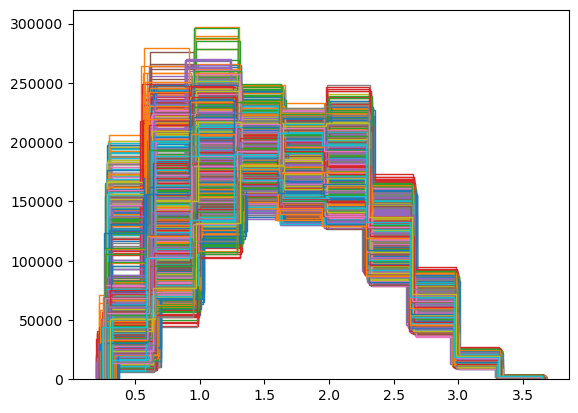

In [24]:
for i in range(0,1400):
   plt.hist((dmat[:,i]),histtype='step',label=i) 

In [25]:
contacts.shape

(1100889, 1500)

In [26]:
count = dict(count)

In [27]:
res_ave = []
c = 0
for i in count.values():
    res_ave.append(contacts[:,c:c+i].mean(1))
    c+=i

In [28]:
res_ave = np.stack(res_ave, axis = 1)

In [29]:
res_ave.shape

(1100889, 20)

In [30]:
#np.save("hphob_dist_matrix.npy", contacts)

In [9]:
#dmat = np.load("/home/apara/Documents/asn/tica/lig_47/hphob/hphob_dist_matrix.npy")

In [31]:
#dmat_intra = distance_matrix(np.arange(1,21),np.arange(1,21), 0,0,trj,"residues", True)[0]

In [2]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import deeptime
from deeptime.decomposition import TICA
import pyemma
from deeptime.clustering import KMeans

<Figure size 640x480 with 0 Axes>

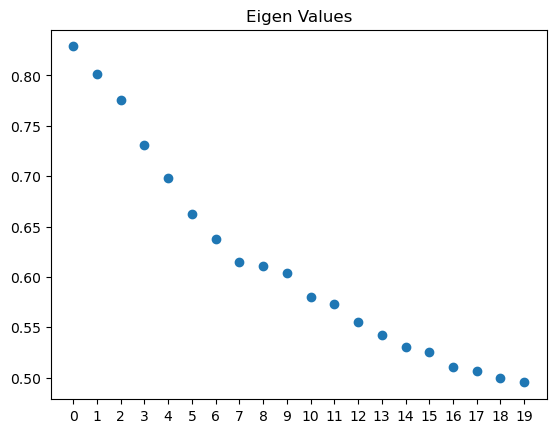

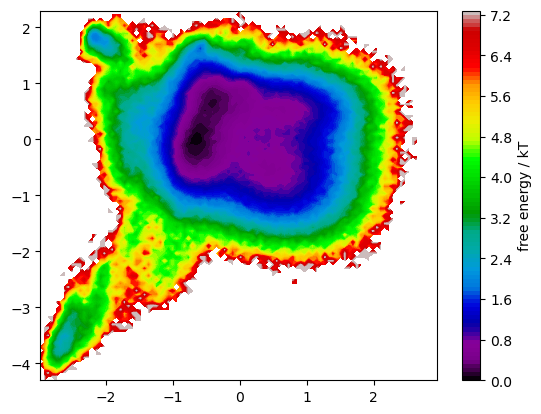

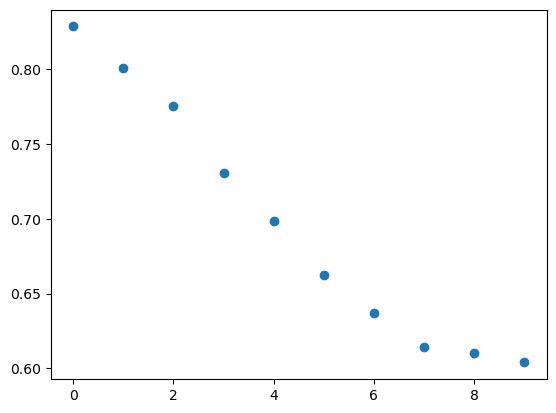

<Figure size 640x480 with 0 Axes>

In [40]:
##adjustable params
space = 1
dim = 2
n_clusters = 4
lag = 10
##
combined = contacts
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()


In [55]:
np.save('fasudil_hphob_tica_combined_10.npy', tica_combined)
np.save('fasudil_hphob_proj_combined_10.npy', proj_combined)
np.save('fasudil_hphob_dtraj_combined_10.npy', dtraj)

In [5]:
dtraj = np.load('fasudil_hphob_dtraj_combined_10.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'fasudil_hphob_dtraj_combined_10.npy'

<BarContainer object of 4 artists>

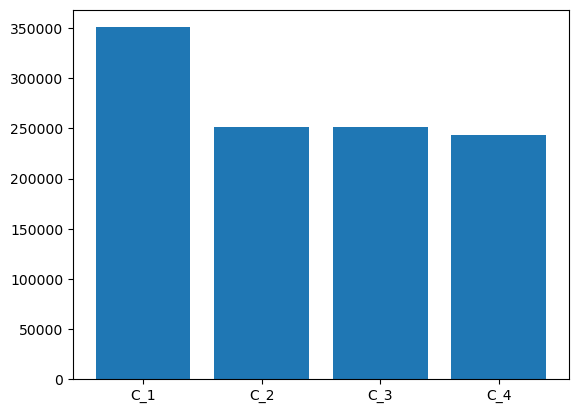

In [41]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

c0 = c0_i.size
c1 = c1_i.size
c2 = c1_i.size
c3 = c3_i.size
size = [c0, c1, c2, c3]
langs = ['C_1', 'C_2', 'C_3', 'C_4']
plt.bar(langs, size)

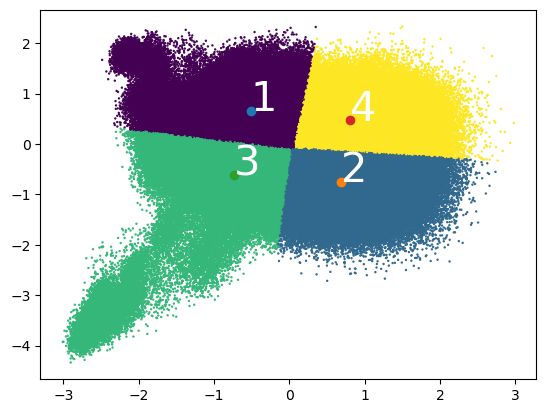

In [42]:
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5)
for j,i in enumerate(clustercenters):
    plt.annotate(f"{j+1}", [i[k] for k in range(2)], color="white", size="30")
    
plt.scatter(clustercenters[0,0], clustercenters[0,1])
plt.scatter(clustercenters[1,0], clustercenters[1,1])
plt.scatter(clustercenters[2,0], clustercenters[2,1])
plt.scatter(clustercenters[3,0], clustercenters[3,1])

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|                                  | 0/47 [00:00<?, ?it/s]

ValueError: x and y must have same first dimension, but have shapes (20,) and (1400,)

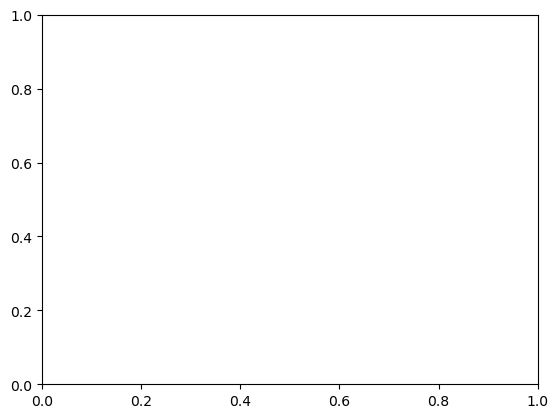

In [17]:
tica_obj = coor.tica(contacts, lag=50)
A = tica_obj.eigenvectors

for i in range(0,4):
 plt.plot(prot_res_renum[0:1400],A[:,i],label='%s'%i)

plt.xticks(prot_res,prot_res,rotation=45)
plt.legend()

In [51]:
    x = [[ 1 2 3 5]
         [ 4 5 6 8]
         [ 7 8 9 11]]

y1 = x[:,0]+x[:,2]    # Sum of columns 0 and 2
y1 = array([4,10,16])
y2 = x[:,1]+x[:,3]    # Sum of columns 1 and 3
y2 = array([7,13,19])

[array([      0,       1,       2, ..., 1110886, 1110887, 1110888]),
 array([     61,      62,      64, ..., 1110864, 1110865, 1110866]),
 array([      6,      10,      13, ..., 1110879, 1110880, 1110881]),
 array([     73,      86,      87, ..., 1110871, 1110872, 1110873])]

In [21]:
y_2 = np.average(contacts[c0_i],axis=0)

In [49]:
y_2.shape

(1400,)

In [25]:
plt.plot(np.average(res_ave[c0_i],axis=0))

NameError: name 'res_ave' is not defined

In [29]:
y_1 = np.sum(c0_i[:3], axis = 0)

In [36]:
np.sum(y_2[:3], axis = 0)

6.419350322155818

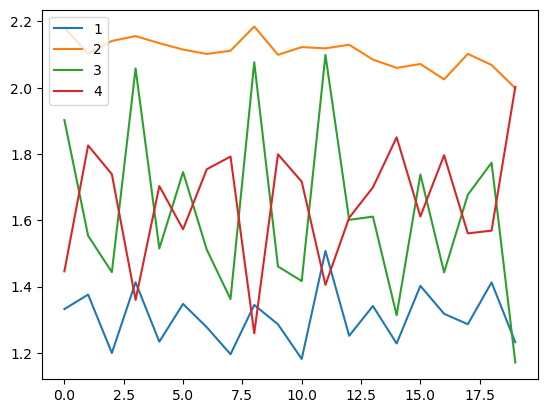

In [43]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

plt.plot(np.average(res_ave[c0_i],axis=0),label='1')
plt.plot(np.average(res_ave[c1_i],axis=0),label='2')
plt.plot(np.average(res_ave[c2_i],axis=0),label='3')
plt.plot(np.average(res_ave[c3_i],axis=0),label='4')
plt.legend()

In [23]:
#contact probabilities
dmat_con_prob = np.sum(dmat_bin, axis =0)/dmat.shape[0]
print (dmat_con_prob)
dmat_con_prob.shape

NameError: name 'dmat_bin' is not defined

In [3]:
!pwd

/home/apara/Documents/asn/tica/lig_47/hphob


In [4]:
dtraj = np.load('/home/apara/Documents/asn/tica/lig_47/hphob/fasudil_hphob_dtraj_combined_10.npy')

In [5]:
#make tick labels
ticklabs = "1,2,3,4".split(",")
#make custom set of colors for each state
nstates = dtraj.max()+1
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nstates)]
clist = clist[::-1]

In [6]:
#make instance of bayesian MSM  to estimate errors from bootstrapping (gibbs sampling)
lagtime = 10
bmsm = pyemma.msm.bayesian_markov_model(dtraj,lagtime,nsamples=10)    
ck = bmsm.cktest(nstates-1,memberships = np.eye(nstates),n_jobs=1,)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[0]: Sampling MSMs:   0%|                                       …

estimating BayesianMSM:   0%|                                                                                 …

In [7]:
#customize pyemma source code
def _add_ck_subplot(cktest, test_index, ax, i, j, ipos=None, jpos=None, y01=True, units='steps', dt=1., **plot_kwargs):
    # plot estimates
    for default in ['color', 'linestyle']:
        if default in plot_kwargs.keys():
            #print("ignoring plot_kwarg %s: %s"%(default, plot_kwargs[default]))
            plot_kwargs.pop(default)
    color = clist[1] ####this is added######

    lest = ax.plot(dt*cktest.lagtimes, cktest.estimates[:, i, j], color="black", **plot_kwargs)
    # plot error of estimates if available
    if cktest.has_errors and cktest.err_est:
        ax.fill_between(dt*cktest.lagtimes, cktest.estimates_conf[0][:, i, j], cktest.estimates_conf[1][:, i, j],
                        color='black', alpha=0.2)
    # plot predictions
    lpred = ax.plot(dt*cktest.lagtimes, cktest.predictions[:, i, j], color=color, linestyle='dashed', **plot_kwargs)
    # plot error of predictions if available
    if cktest.has_errors:
        ax.fill_between(dt*cktest.lagtimes, cktest.predictions_conf[0][:, i, j], cktest.predictions_conf[1][:, i, j],
                        color=color, alpha=0.2)
    # add label
    ax.text(0.1, 0.8, str(i+1)+' ->'+str(j+1), transform=ax.transAxes, weight='bold')
    if y01:
        ax.set_ylim(0, 1)
    # Axes labels
    if ipos is None:
        ipos = i
    if jpos is None:
        jpos = j
    if (jpos == 0):
        ax.set_ylabel('probability')
    if (ipos == cktest.nsets-1):
        ax.set_xlabel('lag time (' + units + ')')
    # return line objects
    return lest, lpred


def plot_cktest(cktest, figsize=None, diag=False,  y01=True, layout=None,
                padding_between=0.1, padding_top=0.075, units='steps', dt=1., **plot_kwargs):
    """Plot of Chapman-Kolmogorov test
    Parameters
    ----------
    cktest : msm.ChapmanKolmogorovValidator or list of msm.ChapmanKolmogorovValidator
        Chapman-Kolmogorov Test, optionally a list of tests which are all 
        plotted into the same set of axes. This assumes that all cktests were
        estimated for the same nstates.
    figsize : shape, default=(10, 10)
        Figure size
    diag : bool, default=False
        Plot only diagonal elements of the test, i.e. self-transition
        probabilities.
    y01 : bool, default=True
        Scale all y-Axes to [0,1]. If True, the y-Axes can be shared
        and the figure is tighter. If False, each y Axis will be scaled
        automatically.
    layout : str or shape or None, default=None
        Organization of subplots. You can specify your own shape. If None,
        an automatic shape will be selected. Use 'wide' for plots that
        span the page width (double-column figures) and 'tall' for
        single-column figures.
    padding_between : float, default=0.1
        padding space between subplots (as a fraction of 1.0)
    padding_top : float, default=0.05
        padding space on top of subplots (as a fraction of 1.0)
    **plot_kwargs : optional keyword arguments for the matplotlib.pylab.plot() call
        The user is allowed to choose values like marker='x', linewidth=3 etc. Note that
        'linestyle' and 'color' are defaults and cannot be changed using plot_kwargs
    Returns
    -------
    fig : Figure object
    axes : Axis objects with subplots
    """
    if not isinstance(cktest, (list, tuple)):
        cktests = [cktest]
    else:
        cktests = cktest
    cktest = cktests[0]
    for test in cktests:
        assert cktest.nsets == test.nsets, "cktests all need same number of sets"
    import matplotlib.pylab as plt
    sharey = y01
    # first fix subfigure layout
    if diag:
        if layout is None or layout == 'wide':
            ncol = min(4, cktest.nsets)
            layout = (int(math.ceil(cktest.nsets / ncol)), ncol)
        elif layout == 'tall':
            nrow = min(4, cktest.nsets)
            layout = (nrow, int(math.ceil(cktest.nsets / nrow)))
    else:
        layout = (cktest.nsets, cktest.nsets)
    # fix figure size
    if figsize is None:
        size_per_subplot = min(3.0, 10.0 / np.max(np.array(layout)))
        figsize = (size_per_subplot*layout[1], size_per_subplot*layout[0])
    # generate subplots
    fig, axes = plt.subplots(layout[0], layout[1], sharex=True, sharey=sharey, figsize=figsize)
    axeslist = list(axes.flatten())
    # line objects
    lest = None
    lpred = None
    # plot
    lests = []
    lpreds = []
    for test_index, test in enumerate(cktests):
        for (k, ax) in enumerate(axeslist):
            if diag and k < cktest.nsets:
                ipos = int(k/layout[1])
                jpos = int(k%layout[1])
                lest, lpred = _add_ck_subplot(test, test_index, ax, k, k, ipos=ipos, jpos=jpos, y01=y01, units=units,
                                              dt=dt, **plot_kwargs)
                k += 1
            else:
                i = int(k/cktest.nsets)
                j = int(k%cktest.nsets)
                lest, lpred = _add_ck_subplot(test, test_index, ax, i, j, y01=y01, units=units, dt=dt, **plot_kwargs)
        lests.append(lest[0])
        lpreds.append(lpred[0])
    # figure legend
    handles = []
    labels = []
    for ix, test in enumerate(cktests):
        predlabel = 'predict {}'.format(ix) if len(cktests) > 1 else 'predict'
        estlabel = 'estimate {}'.format(ix) if len(cktests) > 1 else 'estimate'
        if cktest.has_errors:
            predlabel += '     conf. {:3.1f}%'.format(100.0*cktest.conf)
        handles.append(lests[ix])
        handles.append(lpreds[ix])
        labels.append(predlabel)
        labels.append(estlabel)
    fig.legend(handles, labels, 'upper center', ncol=2, frameon=False,prop={'size': 15})
    # change subplot padding
    plt.subplots_adjust(top=1.0-padding_top, wspace=padding_between, hspace=padding_between)
    # done
    return fig, axes

Text(0.05, 0.5, 'Probability')

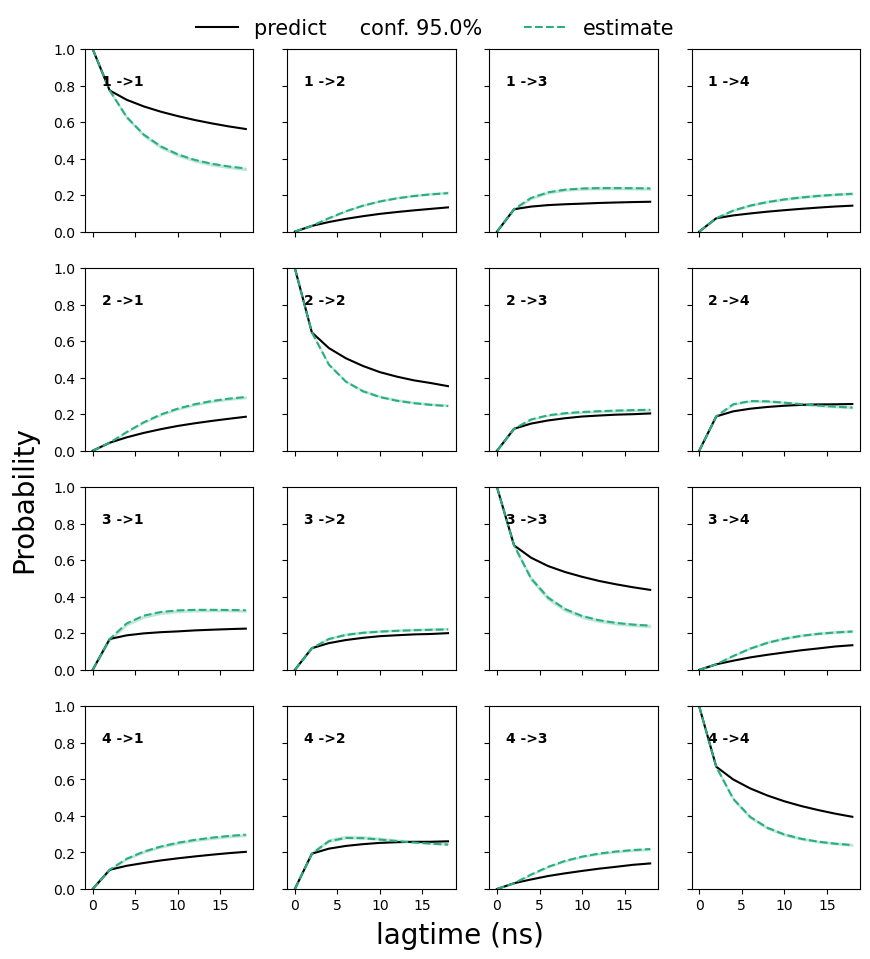

In [8]:
#plot customized CK plot
fig, ax =plot_cktest(ck,figsize=(10,10),padding_top= .05,units = "ns", dt = .2,
                                  padding_between = 0.2, y01=True,layout="wide")
for axi in ax.flat:
    axi.set_xlabel(None)
    axi.set_ylabel(None)
fig.supxlabel("lagtime (ns)",x=0.5,y=.05,size = 20)
fig.supylabel("Probability",x=.05,y=.5,size = 20)

In [9]:
#customize pyemma source code
from pyemma.util.statistics import confidence_interval as _conf
from pyemma.util.types import is_iterable_of_int as _is_iterable_of_int, is_int as _is_int
import numpy as _np
__author__ = 'noe'


def plot_implied_timescales(ITS, ax=None, outfile=None, show_mle=True, show_mean=True,
                            xlog=False, ylog=True, confidence=0.95, refs=None, nits=-1,
                            process=None, units='steps', dt=1., **kwargs):
    r"""Implied timescale plot
    Parameters
    ----------
    ITS : implied timescales object.
        Object whose data will be plotted. Should be of type :class:`ImpliedTimescales <pyemma.msm.ImpliedTimescales>`
        or a 3-tuple with: 1d array of lagtimes, (lagtimes, processes) array of timescales,
        optionally (lagtimes, processes, samples) array of timescales of samples.
    ax : matplotlib Axes object, optional, default = None
        the axes to plot to. When set to None the default Axes object will be used.
    outfile : str, optional, default = None
        output file to write the figure to. When not given, the plot will be displayed
    show_mean : bool, default = True
        Line for mean value will be shown, if available
    show_mle : bool, default = True
        Line for maximum likelihood estimate will be shown
    xlog : bool, optional, default = False
        Iff true, the x-Axis is logarithmized
    ylog : bool, optional, default = True
        Iff true, the y-Axis is logarithmized
    confidence : float, optional, default = 0.95
        The confidence interval for plotting error bars (if available)
    refs : ndarray((m), dtype=float), optional, default = None
        Reference (exact solution or other reference) timescales if known. The number of timescales must match those
        in the ITS object
    nits: integer, default = -1
        Number of implied timescales to be shown. The default behaviour (-1) is to show all timescales available.
        :py:obj:`nits` != -1 and :py:obj:`process` != None are mutually exclusive
    process : iterable of integers, default is None
        list or ndarray((m), dtype=int) containing a list of the processes to be shown. The default behaviour is
        to show all timescales available.
        :py:obj:`process` != None and :py:obj:`nits` != -1 are mutually exclusive
    units: str or list (len=2) of strings, optional, default = 'steps'
        Affects the labeling of the axes. Used with :py:obj:`dt`, allows for changing the physical units of the axes.
        Accepts simple LaTeX math strings, eg. '$\mu$s'
        If this parameter is a list, it will be assumed that units[0] is for the x-axis and units[1] for the y-axis.
    dt: float or list(len=2) of floats, optional, default = 1.0
        Physical time between frames, expressed the units given in :py:obj:`units`. E.g, if you know that each
        frame corresponds to .010 ns, you can use the combination of parameters :py:obj:`dt` =0.01,
        :py:obj:`units` ='ns' to display the implied timescales in ns (instead of frames)
        If this parameter is a list, it will be assumed that dt[0] is for the x-axis and dt[1] for the y-axis.
    **kwargs: Will be passed to pyplot.plot when plotting the MLE datapoints (not the bootstrapped means).
            See the doc of pyplot for more options. Most useful lineproperties like `marker='o'` and/or :markersize=5
    Returns
    -------
    ax : Axes object containing the plot
    """
    if isinstance(ITS, tuple):
        assert len(ITS) in (2, 3)
        lags = _np.asarray(ITS[0])
        timescales = _np.asarray(ITS[1])
        timescales_samples = _np.asarray(ITS[2]) if len(ITS) == 3 and ITS[2] is not None else None
        n_timescales = timescales.shape[1]
        samples_available = timescales_samples is not None
    else:
        lags = ITS.lagtimes
        n_timescales = ITS.number_of_timescales
        timescales = ITS.get_timescales()
        samples_available = ITS.samples_available
        timescales_samples = ITS.timescales_samples
        if timescales_samples is not None:
            timescales_samples = timescales_samples.transpose(1, 2, 0)
    import matplotlib.pyplot as _plt
    # check input
    if ax is None:
        ax = _plt.gca(figsize= (10,6))
    colors = clist ######ADDED#####
    xmax = _np.max(lags)
    srt = _np.argsort(lags)
    # Check the processes to be shown
    if process is not None:
        if nits != -1:
            raise TypeError(
                'optional arguments nits and process are mutually exclusive:', nits, process)
        if not _is_iterable_of_int(process):
            raise ValueError('process has to be an iterable of integers')
        if _np.max(process)+1 > n_timescales:
            raise ValueError(
                'requested process %u, whereas ITS only contains %u timescales' % (
                    _np.max(process), n_timescales))
        # Now that it's for sure that nits==-1,
        # process is iter_of_ints, and the requested processes exist in its object:
        its_idx = process
    else:
        if not _is_int(nits):
            raise TypeError('nits is not an integer, ',nits)
        if nits == -1:
            nits = n_timescales
        its_idx = _np.arange(n_timescales)[:nits]
    # Check units and dt for user error.
    if isinstance(units, list) and len(units) != 2:
        raise TypeError("If units is a list, len(units) has to be = 2")
    if isinstance(dt, list) and len(dt) != 2:
        raise TypeError("If dt is a list, len(dt) has to be = 2")
    # Create list of units and dts for different axis
    if isinstance(units, str):
        units = [units] * 2
    if isinstance(dt, (float, int)):
        dt = [dt] * 2
    for i in its_idx:
        # plot estimate
        if show_mle:
            ax.plot(
                lags[srt] * dt[0], timescales[..., i][srt] * dt[1],
                color=colors[i % len(colors)], **kwargs)
        # sample available?
        if samples_available:
            # plot sample mean
            process_samples = timescales_samples[:, i, :].T
            if show_mean:
                sample_mean = _np.mean(process_samples, axis=0)
                ax.plot(
                    lags[srt] * dt[0], sample_mean[srt] * dt[1], marker='o',
                    color=colors[i % len(colors)], linestyle='dashed')
            lconf, rconf = _conf(process_samples, conf=confidence)
            ax.fill_between(
                lags[srt] * dt[0], lconf[srt] * dt[1], rconf[srt] * dt[1],
                alpha=0.2, color=colors[i % len(colors)])
        # reference available?
        if refs is not None:
            tref = refs[i] * dt[1]
            ax.plot([0, min(tref, xmax) * dt[0]], [tref, tref], color='black', linewidth=1)
    # cutoff
    ax.plot(lags[srt] * dt[0], lags[srt] * dt[1], linewidth=2, color='black')
    ax.set_xlim([1.0 * dt[0], xmax * dt[0]])
    ax.fill_between(
        lags[srt] * dt[0], ax.get_ylim()[0]*_np.ones(len(lags))*dt[1], lags[srt] * dt[1],
        alpha=0.2, color='grey')
    # formatting
    ax.set_xlabel('lag time / %s' % units[0])
    ax.set_ylabel('timescale / %s' % units[1])
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    # show or save
    if outfile is not None:
        _plt.savefig(outfile)
    return ax

estimating BayesianMSM:   0%|                                                                                 …

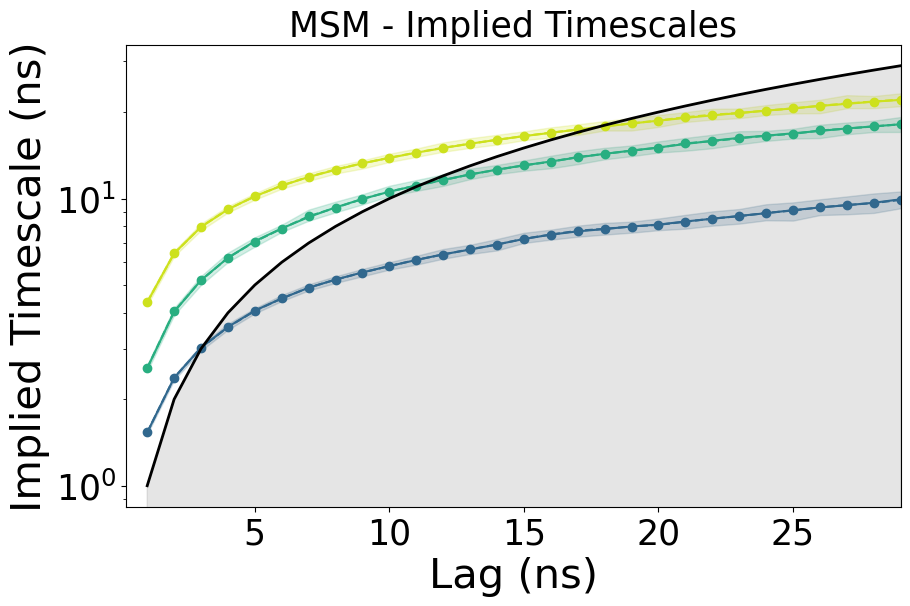

In [10]:
its = pyemma.msm.its(dtraj,np.arange(5,150,5),nits=nstates-1, errors="bayes", nsamples = 100,
                    n_jobs=1, )
fig,ax = plt.subplots(1,figsize=(10,6))
plot_implied_timescales(its,units="ns", dt=.2,ax=ax)
ax.set_xlabel("Lag (ns)",size=30)
ax.set_ylabel("Implied Timescale (ns)",size=30)
ax.set_title("MSM - Implied Timescales",size=25)
ax.tick_params("both", labelsize=25)

In [11]:
#stationary distribution errors
stat_error_l,stat_error_r = bmsm.sample_conf("stationary_distribution") #this estimate has the mean added to it
#above is a computation of the 95% confidence interval
stat_dist_mean = bmsm.sample_mean("stationary_distribution")
stat_dist_error = abs(np.stack([stat_error_l,stat_error_r]) - stat_dist_mean)

(0.5, 4.5)

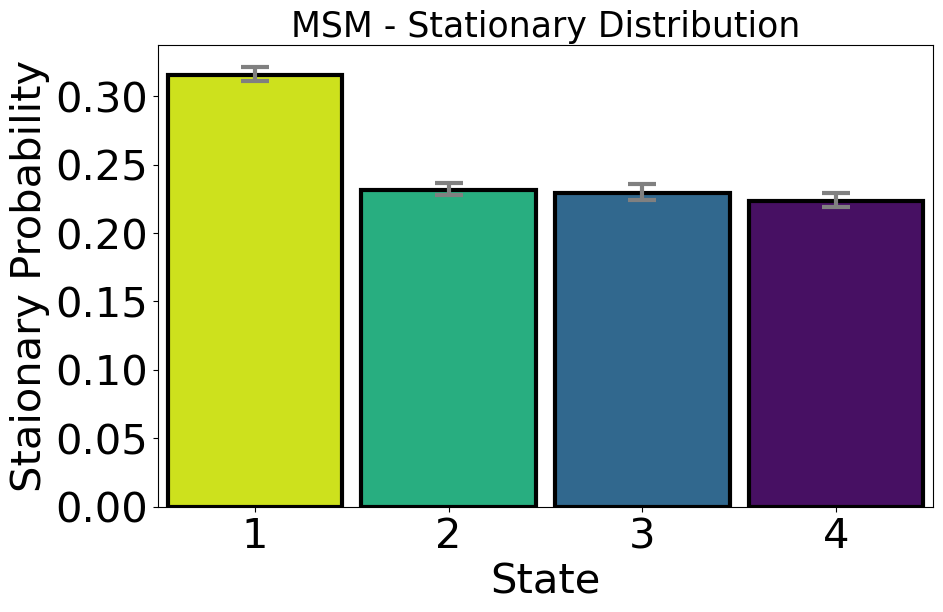

In [12]:
plt.figure(figsize = (10,6))
plt.bar(np.arange(1,nstates+1),stat_dist_mean,yerr = stat_dist_error,
        ecolor="grey",color=clist,capsize=10,width=.9,linewidth=3, edgecolor = "black",
        align="center",error_kw=dict(capthick=3,lw=3))
plt.xticks(np.arange(1,nstates+1), ticklabs)
plt.xlabel("State", size=30)
plt.ylabel("Staionary Probability", size=30)
plt.title("MSM - Stationary Distribution",size=25)
plt.xticks(size = 30)
plt.yticks(size = 30)
plt.xlim(.5,nstates+.5)

In [13]:
def plot_mat_error(mat,emat,title,unit,cbarlabel,
                   textsize,textcolor,cmap,ticklabs):
        """mat = square matrix
        unit = string specifying the units"""
        fig,ax = plt.subplots(1,figsize=(20,20))
        s = ax.imshow(mat, cmap=cmap)
        for i in range(len(mat)):
            for j in range(len(mat)):
                c = mat[j, i]
                e = emat[j,i]
                ax.text(i, j,f"{np.round(c,1)}$\pm${np.round(e,2)}{unit}",
                        va='center', ha='center', color = textcolor,size=textsize,weight="bold")
        ax.set_yticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_xticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_ylabel(r"$State_{i}$", size=45)
        ax.set_xlabel(r"$State_{j}$", size=45)
        cb = plt.colorbar(s,ax=ax,label=cbarlabel,fraction=0.046,pad=0.04)
        cb.set_label(cbarlabel, size=40)
        cb.ax.tick_params(labelsize=30)
        ax.set_title(title, size = 45)
        plt.show()
        return

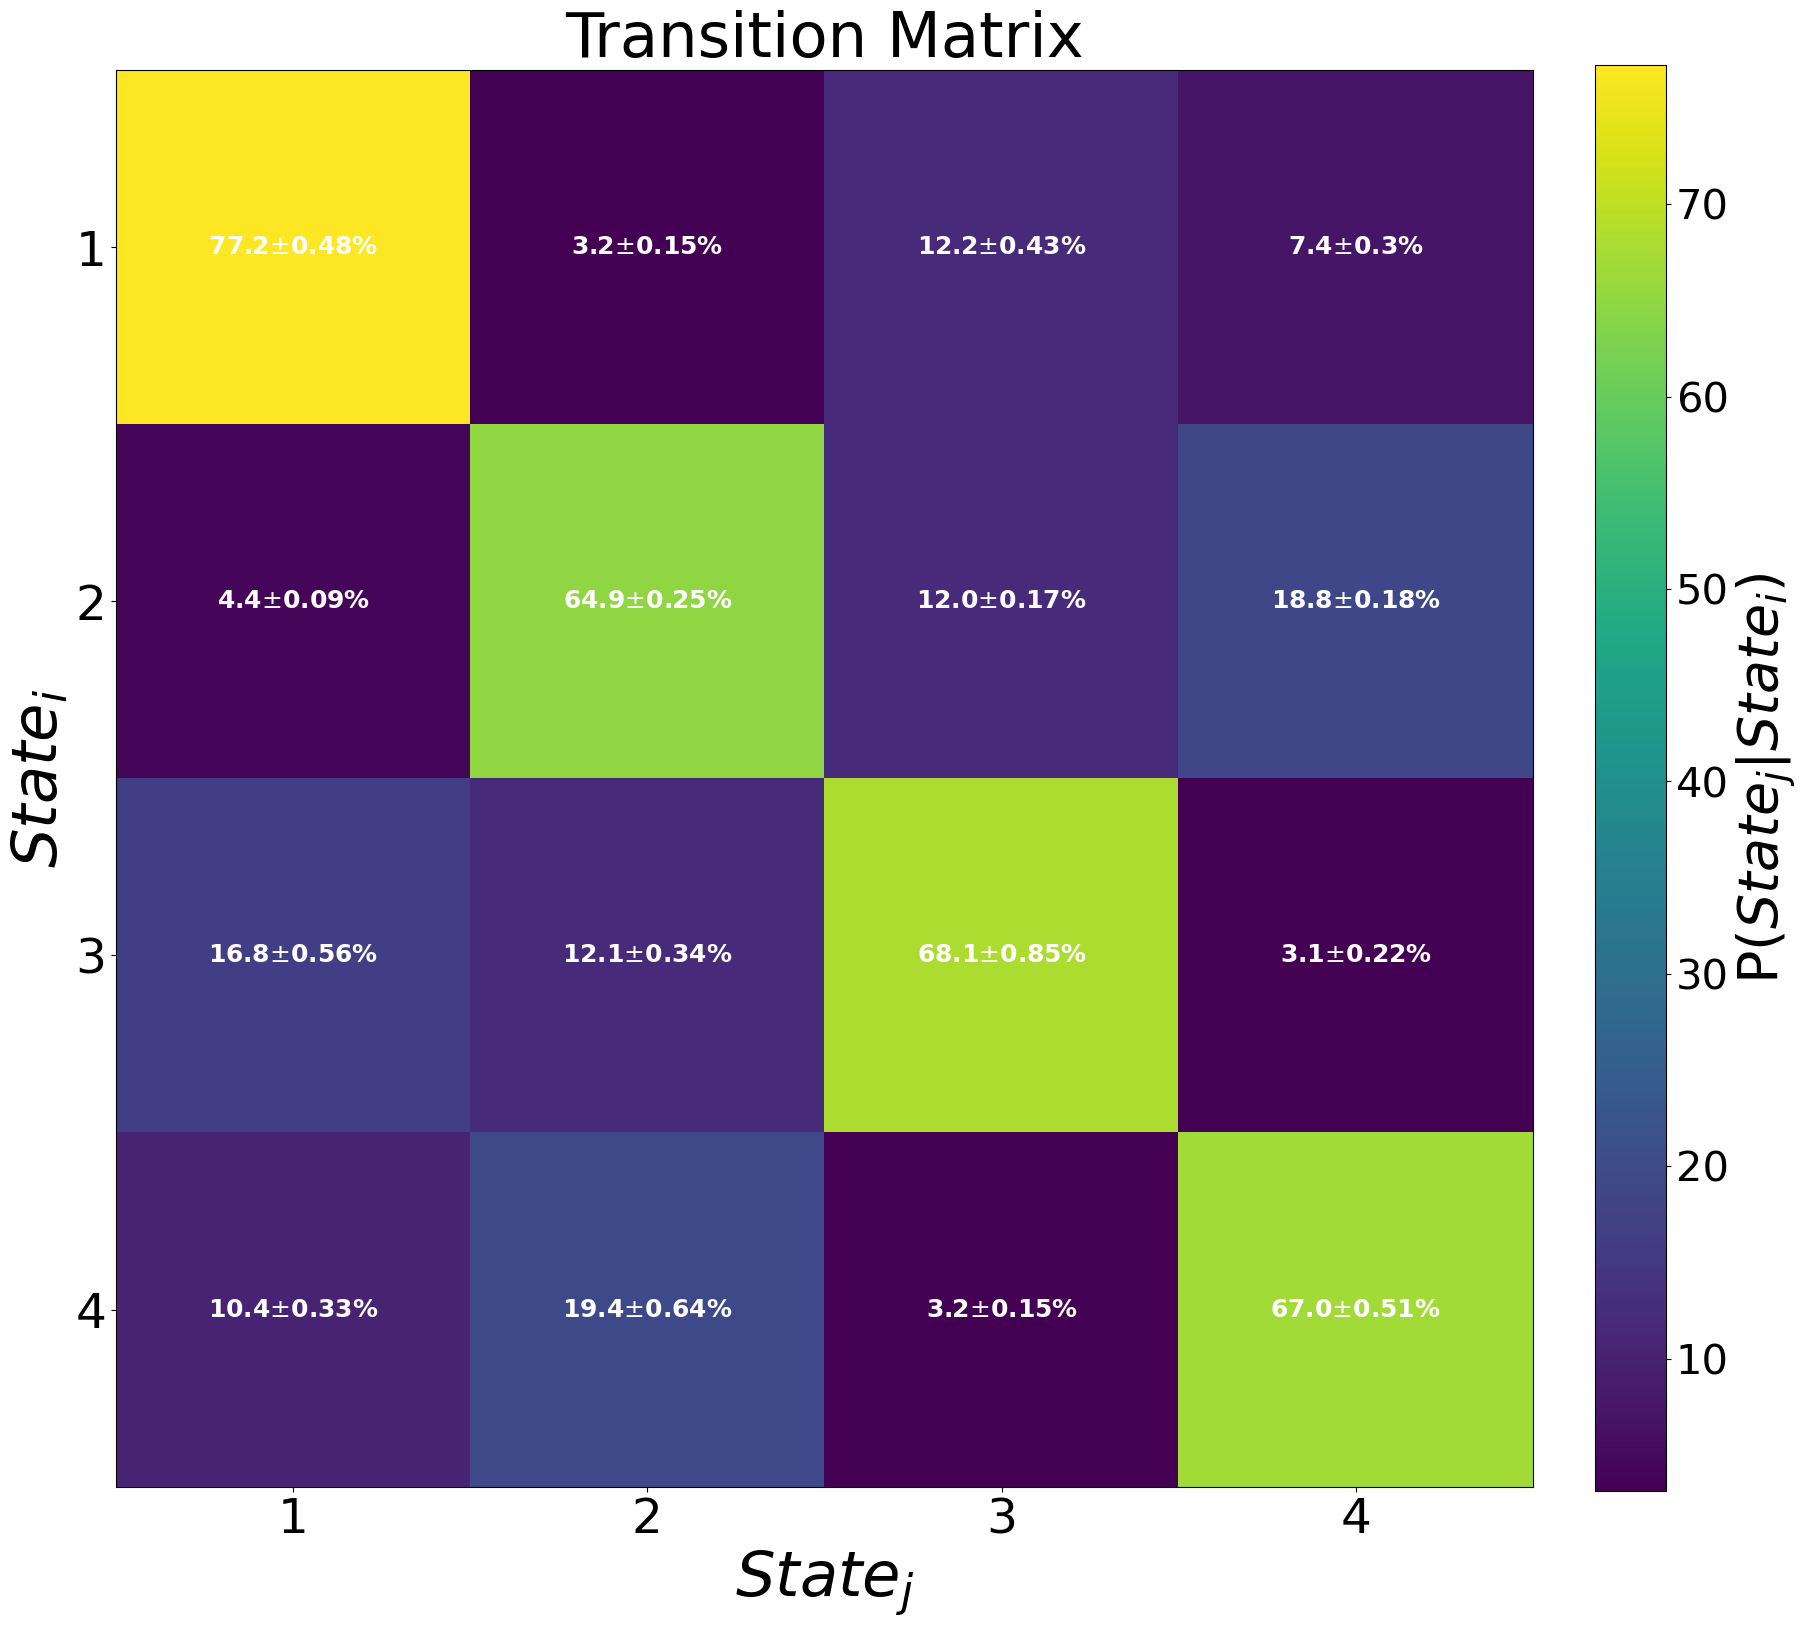

In [14]:
#transition matrix errors
tmat_l,tmat_r = bmsm.sample_conf("transition_matrix")
tmat = bmsm.sample_mean("transition_matrix")
rel_tmat_error = (abs(tmat-tmat_l)+abs(tmat-tmat_r))/2
tmat *= 100
rel_tmat_error *= 100

plot_mat_error(tmat,rel_tmat_error,"Transition Matrix","%",
               r"P($State_{j}$|$State_{i}$)",18,"white","viridis",ticklabs )

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


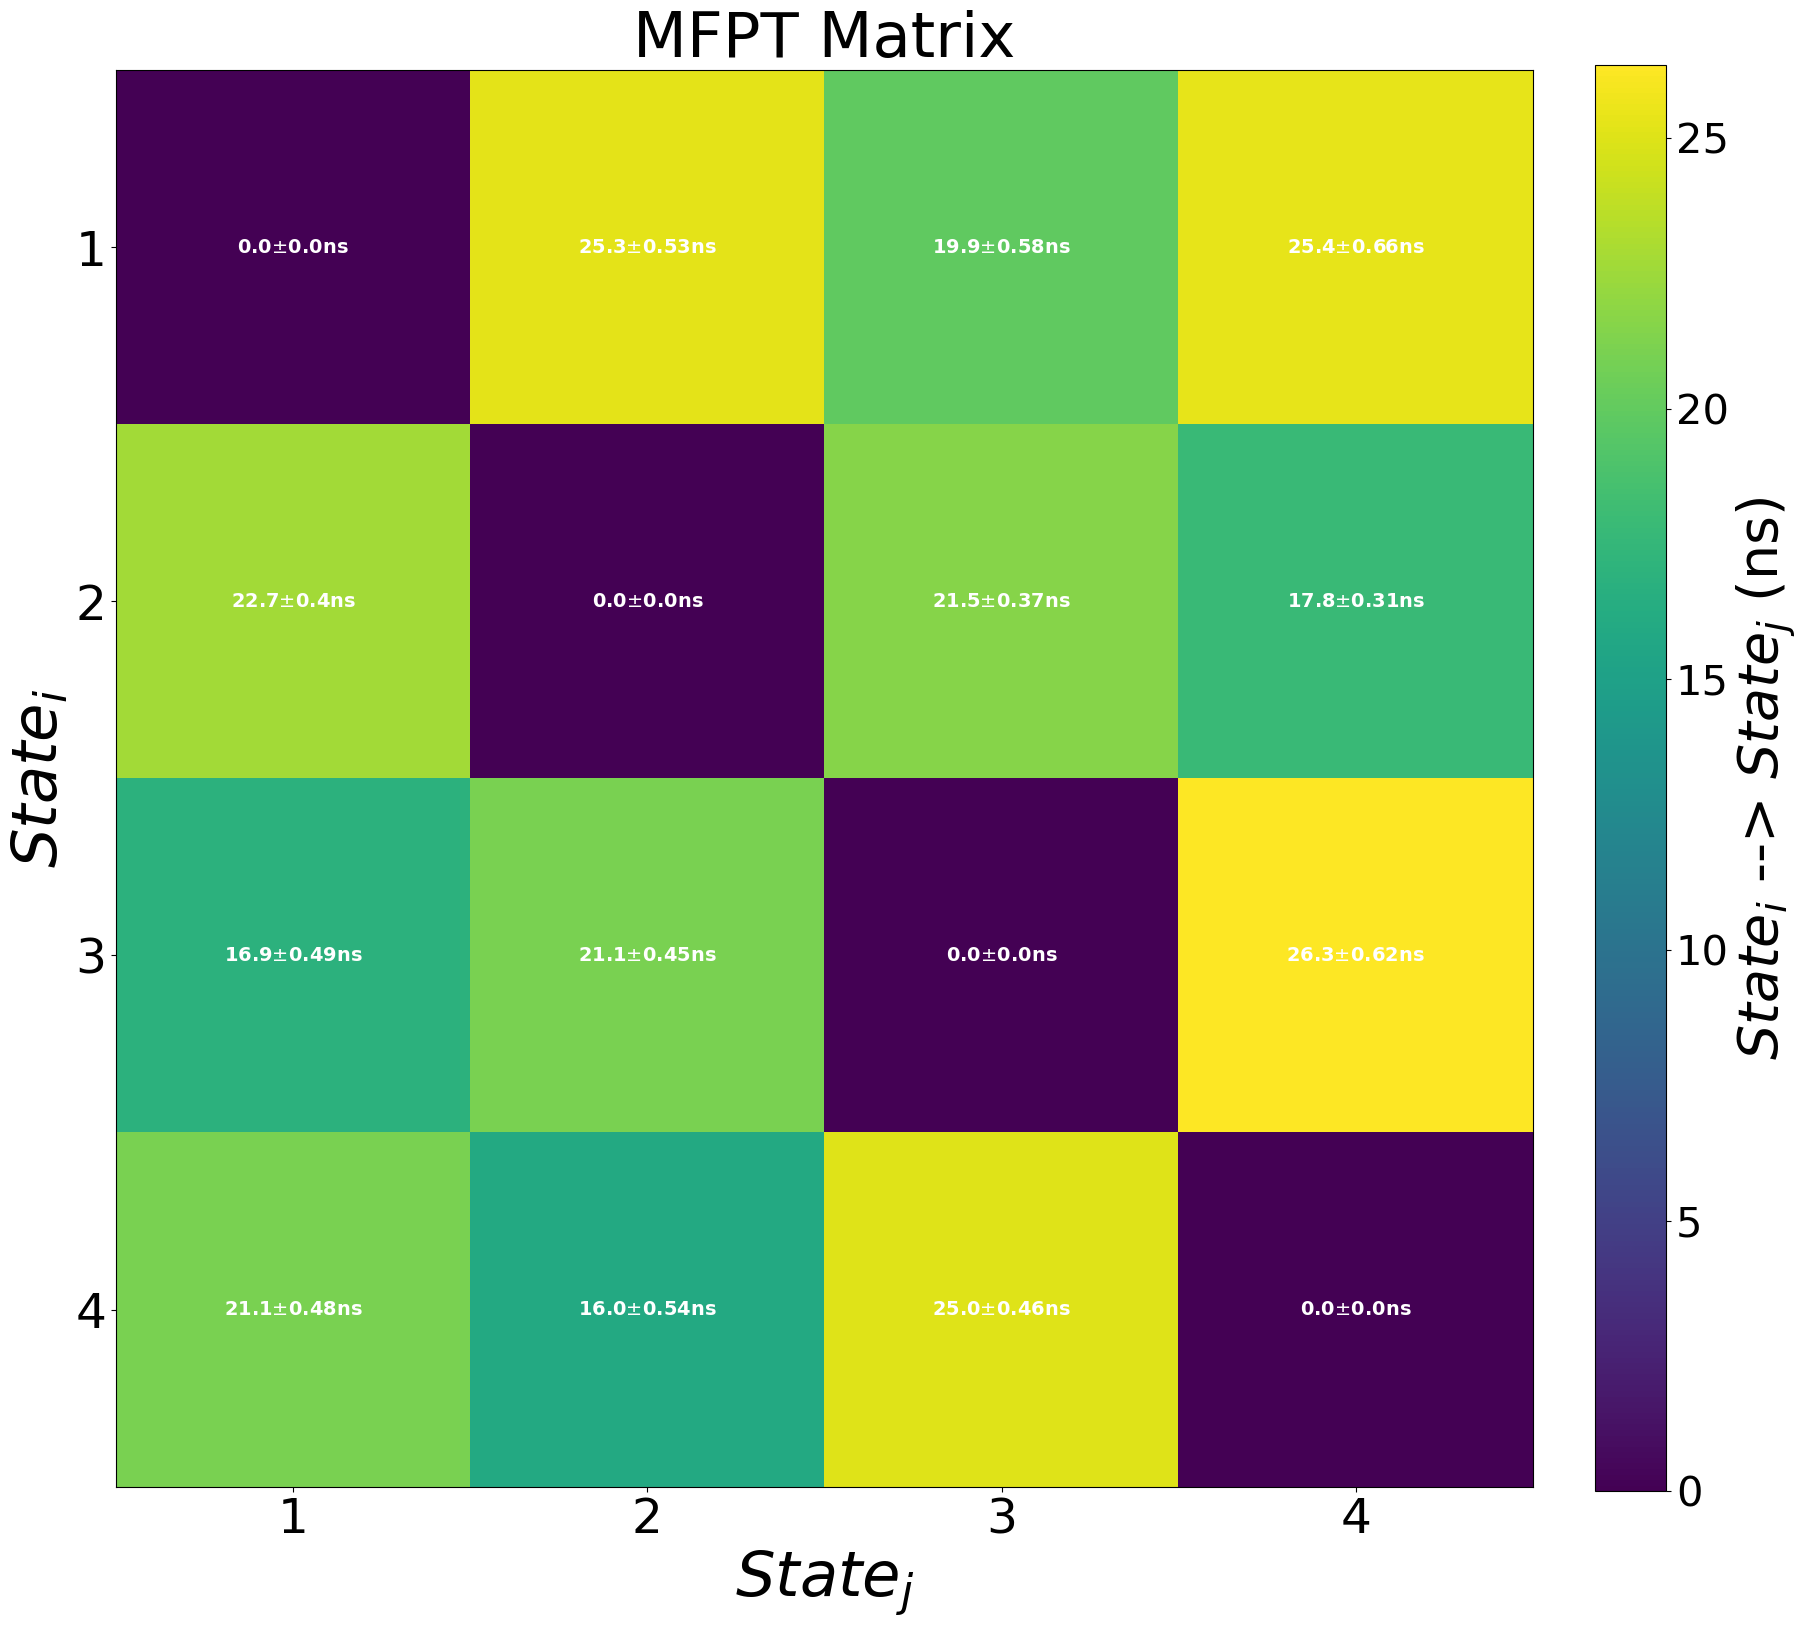

In [15]:
mfpt_error = np.zeros((nstates,nstates))
mfpt_mean = np.zeros((nstates,nstates))
for i in range(nstates):
    for j in range(nstates):
        mean = bmsm.sample_mean("mfpt", i,j)*(.2)
        mfpt_mean[i,j] = mean
        l,r = np.array(bmsm.sample_conf("mfpt", i,j))*(.2)
        mfpt_error[i,j] = (abs(mean-r)+abs(mean-l))/2
        
        
plot_mat_error(mfpt_mean,mfpt_error,"MFPT Matrix","ns",r"$State_{i}$ --> $State_{j}$ (ns)",
         14,"white","viridis",ticklabs)

In [44]:
def makem(ddtraj,nsets,lag):
    msm = pyemma.msm.estimate_markov_model(ddtraj, lag=lag)
    print(msm.score(ddtraj))
    #pyemma.plots.plot_cktest(msm.cktest(nsets=nsets,memberships=np.eye(nsets)))
    #plt.tight_layout()
    #plt.figure()
    lags_scale = np.arange(1,20)
    #its = pyemma.msm.its(ddtraj,lags = lags_scale, nits=nsets-1,errors = None)
    #pyemma.plots.plot_implied_timescales(its)
    return msm

In [45]:
#dmat
msm = makem(dtraj, 4, 10)

06-12-22 22:09:23 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[0] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
2.0937538488716503


([<matplotlib.axis.XTick at 0x7fac29c35690>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

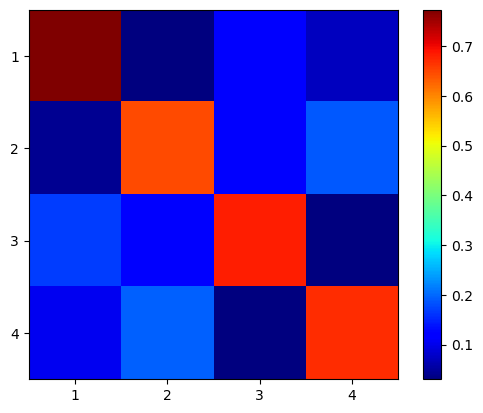

In [46]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [47]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 128.05539493296232
mfpt 0-2 is 98.92530870047408
mfpt 0-3 is 128.50937951327165
mfpt 1-0 is 112.51605227899987
mfpt 1-2 is 107.10717476507178
mfpt 1-3 is 90.05370967330444
mfpt 2-0 is 83.44855383922747
mfpt 2-1 is 107.16976255778764
mfpt 2-3 is 133.29898755258097
mfpt 3-0 is 104.23885997235529
mfpt 3-1 is 81.3225327863505
mfpt 3-2 is 124.50522287291119


In [48]:
msm = makem(dtraj, 4, 50)

06-12-22 22:09:25 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[1] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
1.4186098624465355


([<matplotlib.axis.XTick at 0x7fac29c41d80>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

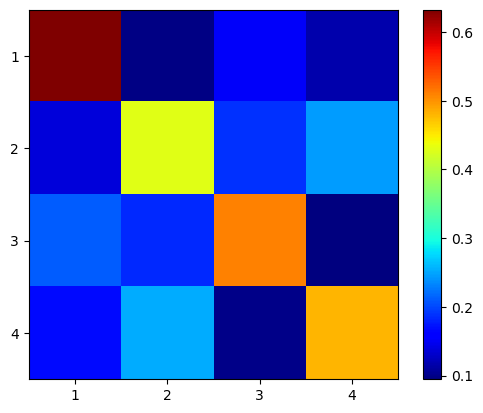

In [49]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [50]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 345.9265931469085
mfpt 0-2 is 338.3912942923262
mfpt 0-3 is 372.6495969661259
mfpt 1-0 is 306.7551496536872
mfpt 1-2 is 325.96185581408776
mfpt 1-3 is 300.78003304614367
mfpt 2-0 is 275.1561251565576
mfpt 2-1 is 301.89813017154046
mfpt 2-3 is 375.61760518628046
mfpt 3-0 is 298.00620861473783
mfpt 3-1 is 265.30808818797686
mfpt 3-2 is 364.2093859706611


In [51]:
#dmat_sig
msm = makem(dtraj, 4, 100)

06-12-22 22:09:27 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[2] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
1.1949926169980372


([<matplotlib.axis.XTick at 0x7fac29b53760>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

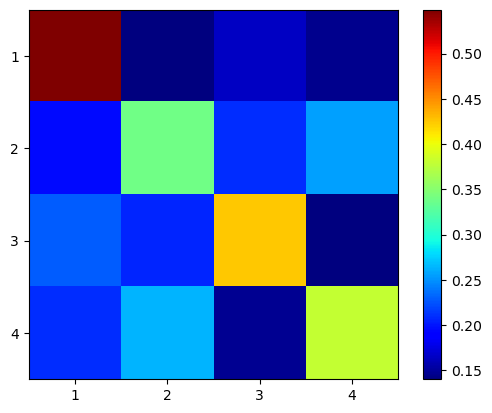

In [52]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [53]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 561.8249469292144
mfpt 0-2 is 586.1094748077913
mfpt 0-3 is 602.9558569126366
mfpt 1-0 is 482.456878630941
mfpt 1-2 is 555.56543511919
mfpt 1-3 is 519.6711048082523
mfpt 2-0 is 463.3829266476061
mfpt 2-1 is 512.2069552572784
mfpt 2-3 is 599.6255780623587
mfpt 3-0 is 476.2223555580719
mfpt 3-1 is 472.30567175196103
mfpt 3-2 is 595.6186248679794


In [54]:
np.shape(msm)

()

In [56]:
trj[frames_cl[0]].save_dcd("/home/apara/Documents/asn/tica/lig_47/hphob/lig47_hphob_cluster_1.dcd") #save frames
trj[frames_cl[1]].save_dcd("/home/apara/Documents/asn/tica/lig_47/hphob/lig47_hphob_cluster_2.dcd") #save frames
trj[frames_cl[2]].save_dcd("/home/apara/Documents/asn/tica/lig_47/hphob/lig47_hphob_cluster_3.dcd") #save frames
trj[frames_cl[3]].save_dcd("/home/apara/Documents/asn/tica/lig_47/hphob/lig47_hphob_cluster_4.dcd") #save frames

In [ ]:
#dists = np.arange(0, 10, 0.1)
def sigmoid(x):
    z = np.exp((-4*x+4))
    sig = 1- 1 / (1 + z)
    return sig

dmat_sig=sigmoid(contacts)

for i in range(0,20):
   plt.hist((dmat_sig[:,i]),histtype='step',bins=20,label=i) 

print (dmat_sig)

No handles with labels found to put in legend.


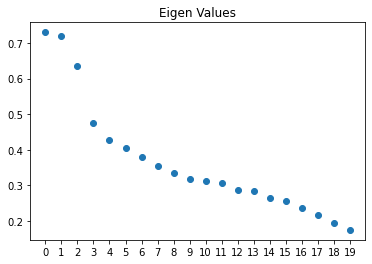

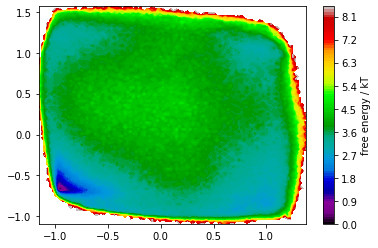

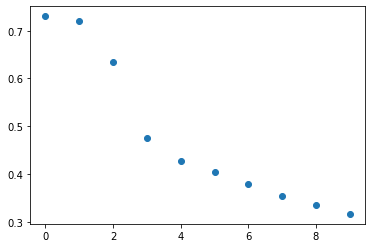

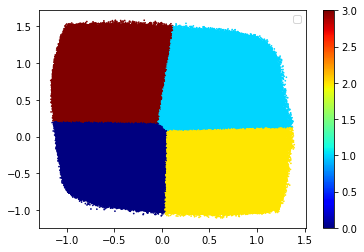

In [59]:
##adjustable params
space = 1
dim = 2
n_clusters = 4
lag = 10
##
combined = dmat_sig
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5,cmap = "jet")
plt.colorbar()
plt.legend()

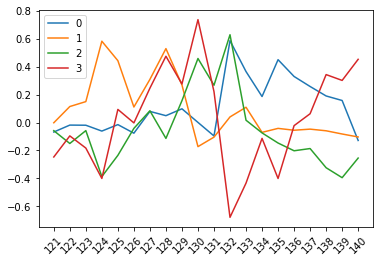

In [60]:
tica_obj = coor.tica(dmat_sig, lag=10)
A = tica_obj.eigenvectors

for i in range(0,4):
 plt.plot(prot_res_renum[0:20],A[:,i],label='%s'%i)

plt.xticks(prot_res,prot_res,rotation=45)
plt.legend()

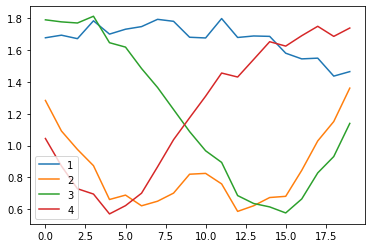

In [61]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

plt.plot(np.average(dmat[c0_i],axis=0),label='1')
plt.plot(np.average(dmat[c1_i],axis=0),label='2')
plt.plot(np.average(dmat[c2_i],axis=0),label='3')
plt.plot(np.average(dmat[c3_i],axis=0),label='4')
plt.legend()

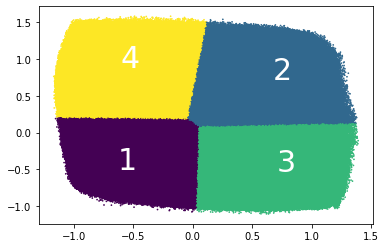

In [62]:
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5)
for j,i in enumerate(clustercenters):
    plt.annotate(f"{j+1}", [i[k] for k in range(2)], color="white", size="30")

In [63]:
def makem(ddtraj,nsets,lag):
    msm = pyemma.msm.estimate_markov_model(ddtraj, lag=lag)
    print(msm.score(ddtraj))
    pyemma.plots.plot_cktest(msm.cktest(nsets=nsets,memberships=np.eye(nsets)))
    plt.tight_layout()
    plt.figure()
    lags_scale = np.arange(1,20)
    its = pyemma.msm.its(ddtraj,lags = lags_scale, nits=nsets-1,errors = None)
    pyemma.plots.plot_implied_timescales(its)
    return msm

31-10-22 03:58:34 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[36] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

2.310110721410024


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.59it/s]


31-10-22 03:58:37 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[41] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

1.9320556913062963


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.16it/s]


31-10-22 03:58:39 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[46] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

1.5570643002259803


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.55it/s]


31-10-22 03:58:42 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[51] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

1.4482127784058076


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.58it/s]


31-10-22 03:58:44 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[56] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

1.3658340068737398


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.16it/s]


31-10-22 03:58:47 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[61] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

1.3025917017243696


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.62it/s]


array([MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=5, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
       MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=10, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
       MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=20, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, st

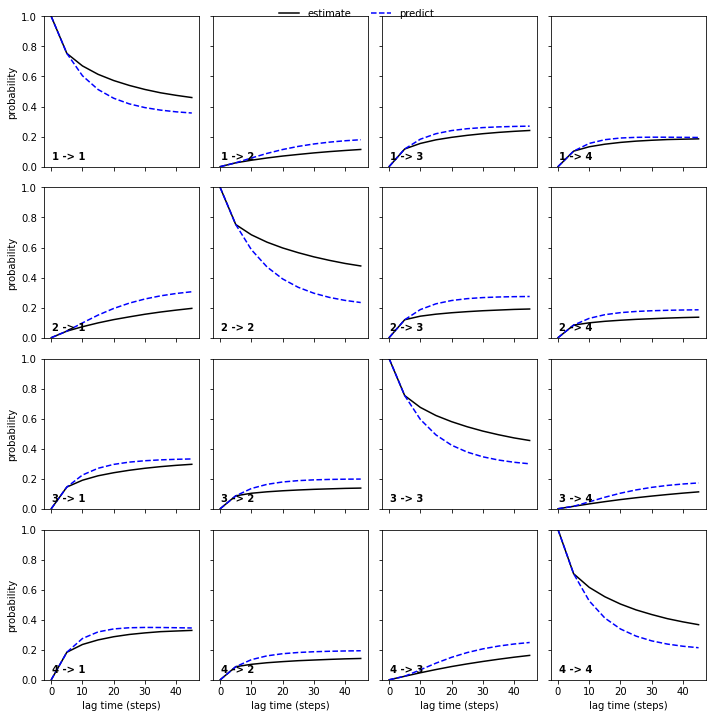

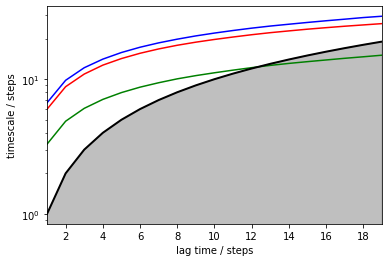

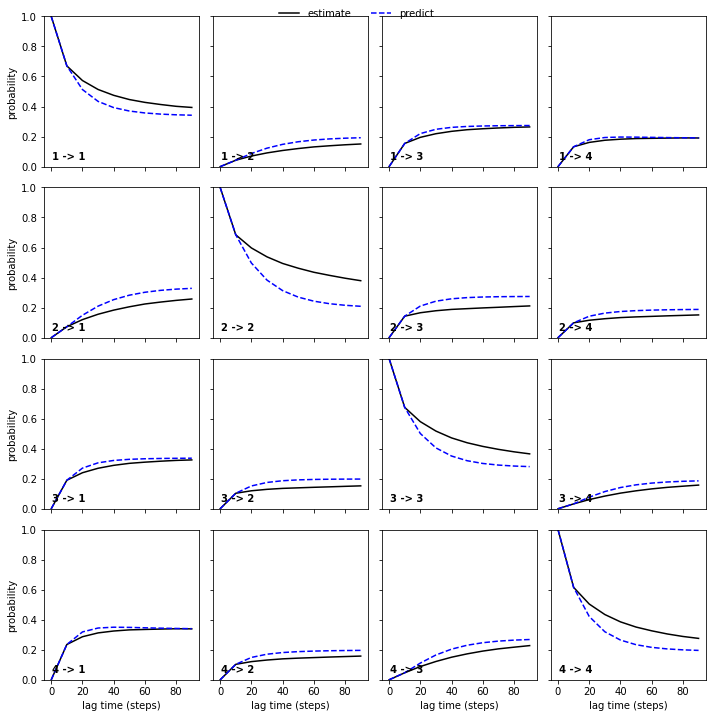

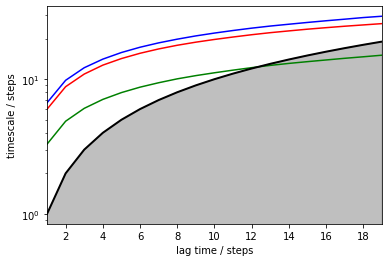

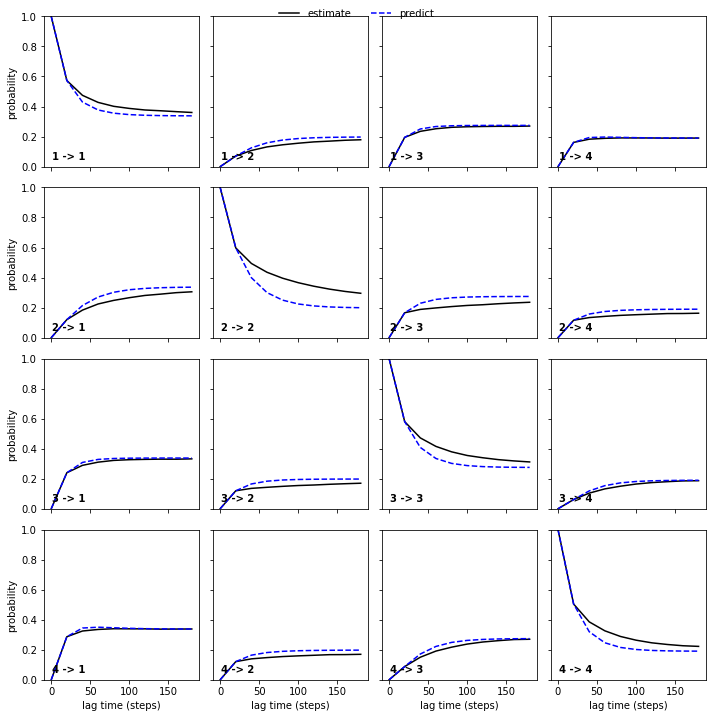

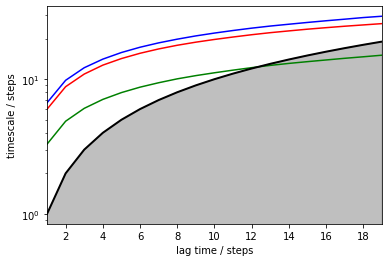

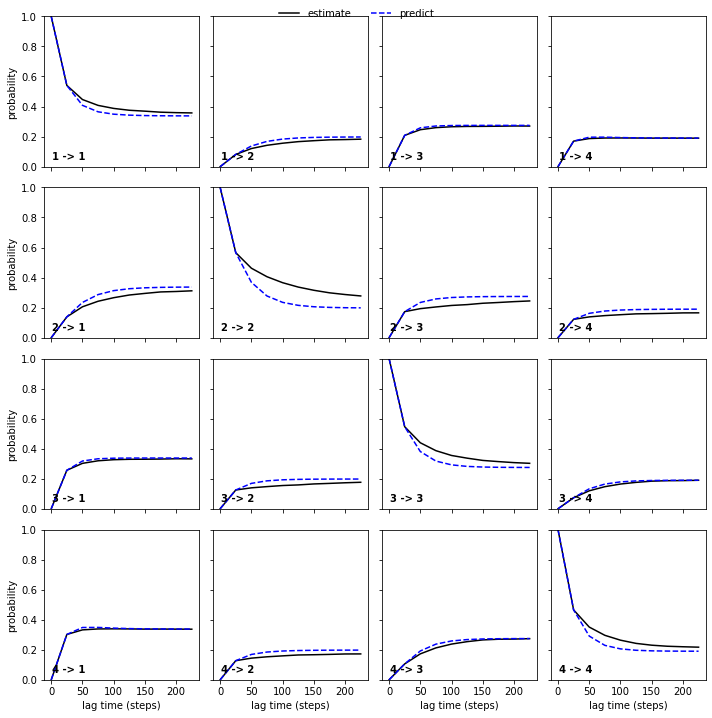

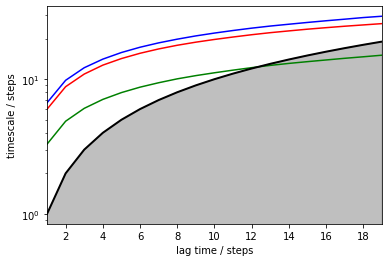

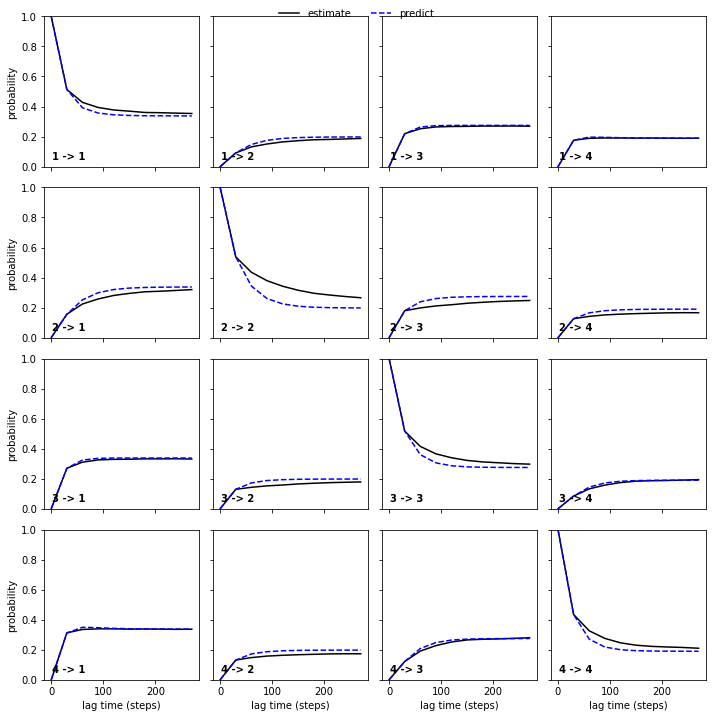

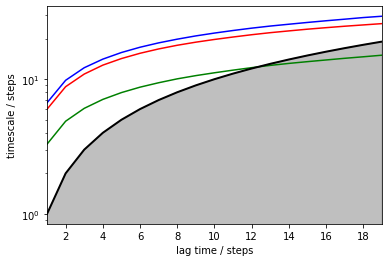

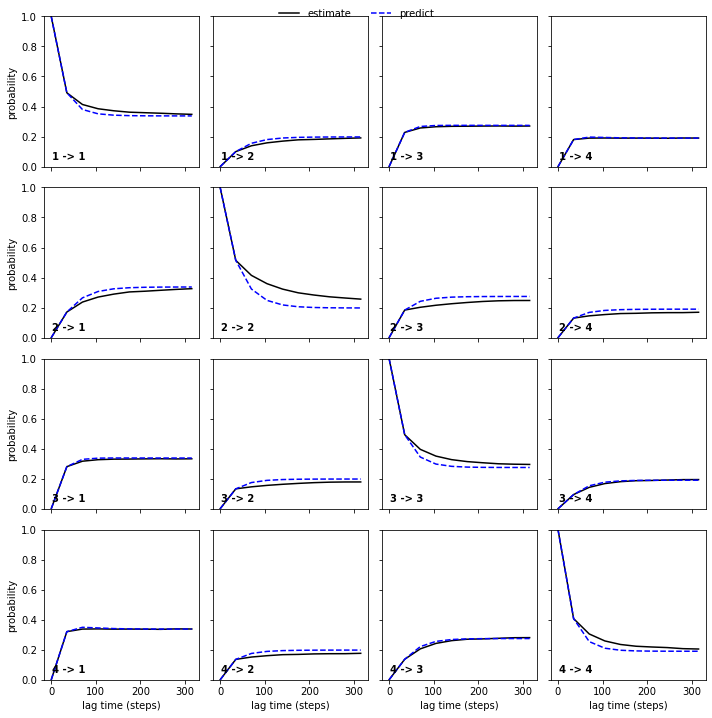

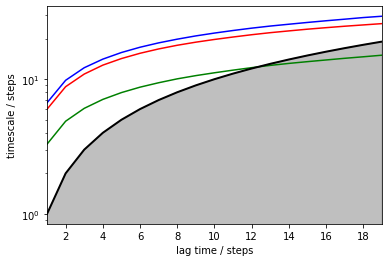

In [64]:
#dmat_sig
msm = []
for i in [5,10,20,25,30,35]:
    msm.append(makem(dtraj, 4, i))
np.hstack(msm)

([<matplotlib.axis.XTick at 0x7fc7dde7cc70>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

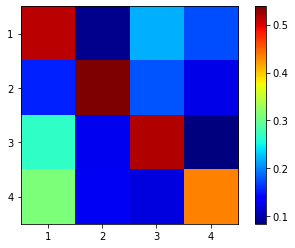

In [65]:
plt.imshow(msm[4].transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [62]:
trj[frames_cl[0]].save_dcd("/Users/achakrab/Documents/asn/tica/fusadil_sig_cluster_1.dcd") #save frames
trj[frames_cl[1]].save_dcd("/Users/achakrab/Documents/asn/tica/fusadil_sig_cluster_2.dcd") #save frames
trj[frames_cl[2]].save_dcd("/Users/achakrab/Documents/asn/tica/fusadil_sig_cluster_3.dcd") #save frames
trj[frames_cl[3]].save_dcd("/Users/achakrab/Documents/asn/tica/fusadil_sig_cluster_4.dcd") #save frames

<Figure size 432x288 with 0 Axes>

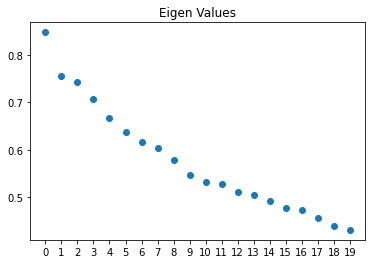

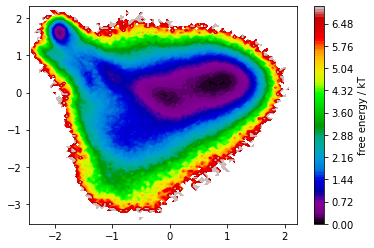

<Figure size 432x288 with 0 Axes>

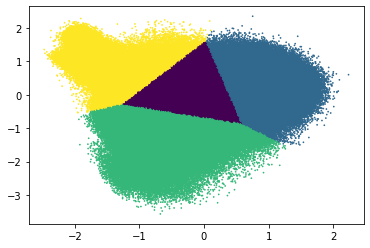

<Figure size 432x288 with 0 Axes>

In [63]:
#distance all to all with single spacing
##adjustable params
space = 4
dim = 2
n_clusters = 4
lag = 20
##
combined = np.concatenate([dmat,dmat_intra[:,res_space(20,space)]], axis = 1)
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
#plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl, clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5)
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()

100%|█████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.44s/it]


ValueError: x and y must have same first dimension, but have shapes (20,) and (260,)

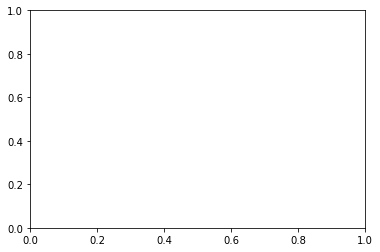

In [87]:
tica_obj = coor.tica(combined, lag=10)
A = tica_obj.eigenvectors

for i in range(0,4):
 plt.plot(prot_res_renum[0:20],A[:,i],label='%s'%i)

plt.xticks(prot_res,prot_res,rotation=45)
plt.legend()

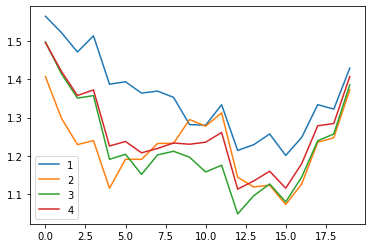

In [52]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

plt.plot(np.average(dmat[c0_i],axis=0),label='1')
plt.plot(np.average(dmat[c1_i],axis=0),label='2')
plt.plot(np.average(dmat[c2_i],axis=0),label='3')
plt.plot(np.average(dmat[c3_i],axis=0),label='4')
plt.legend()

In [53]:
population = [len(i)/trj.n_frames for i in frames_cl]
population_percentage = [100*len(i)/trj.n_frames for i in frames_cl]

In [54]:
def makem(ddtraj,nsets,lag):
    msm = pyemma.msm.estimate_markov_model(ddtraj, lag=lag)
    print(msm.score(ddtraj))
    pyemma.plots.plot_cktest(msm.cktest(nsets=nsets,memberships=np.eye(nsets)))
    plt.tight_layout()
    plt.figure()
    lags_scale = np.arange(1,20)
    its = pyemma.msm.its(ddtraj,lags = lags_scale, nits=nsets-1,errors = None)
    pyemma.plots.plot_implied_timescales(its)
    return msm

24-09-22 22:32:48 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[75] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

2.6440771322824594


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 17.54it/s]


24-09-22 22:32:51 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[80] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

2.4768316678255675


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 18.71it/s]


24-09-22 22:32:54 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[85] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

2.0010569079104283


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 19.81it/s]


24-09-22 22:32:57 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[90] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.759872532122256


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 18.84it/s]


24-09-22 22:33:00 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[95] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.2834687232471567


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 18.55it/s]


24-09-22 22:33:03 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[100] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.1687867719869431


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 18.39it/s]


array([MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=5, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
       MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=10, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
       MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=50, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, st

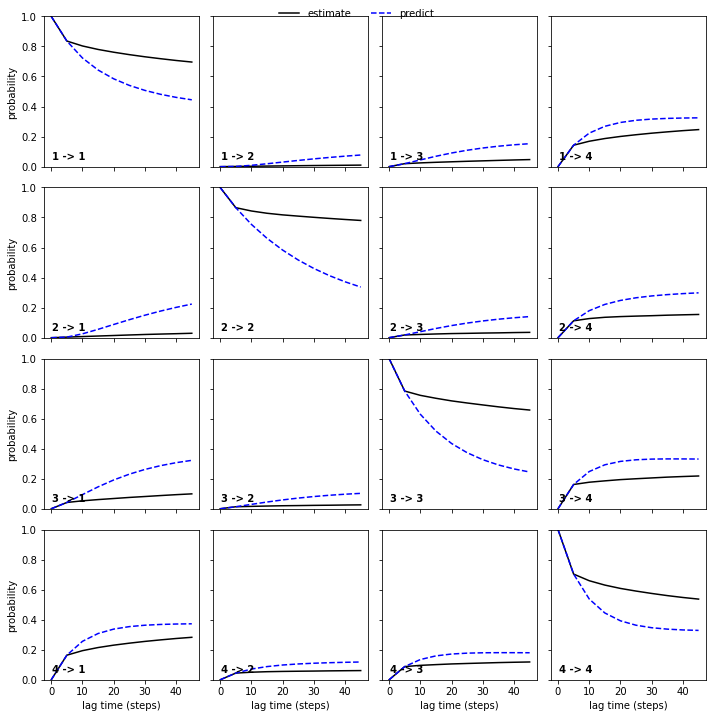

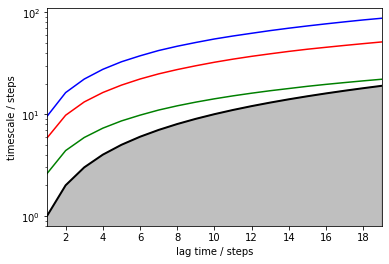

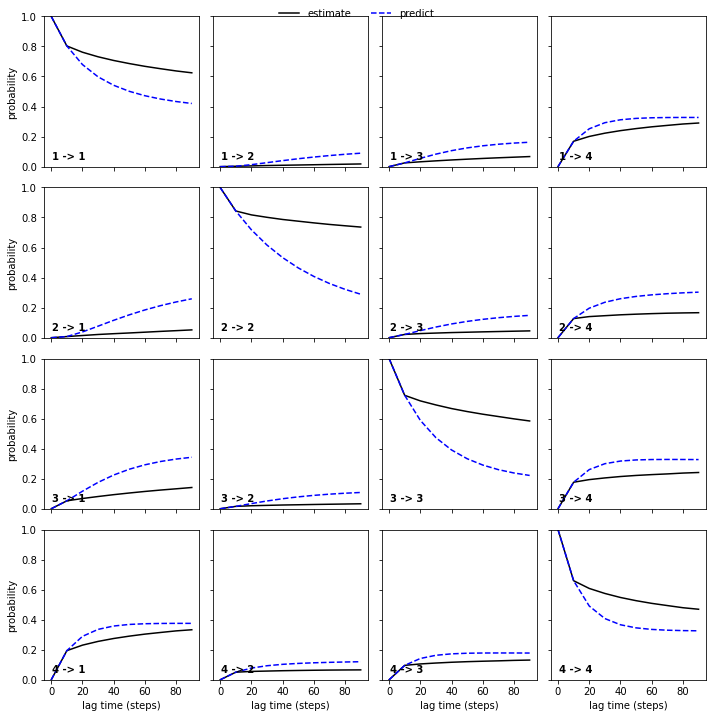

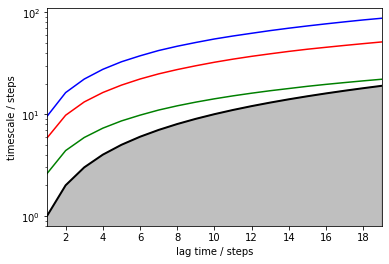

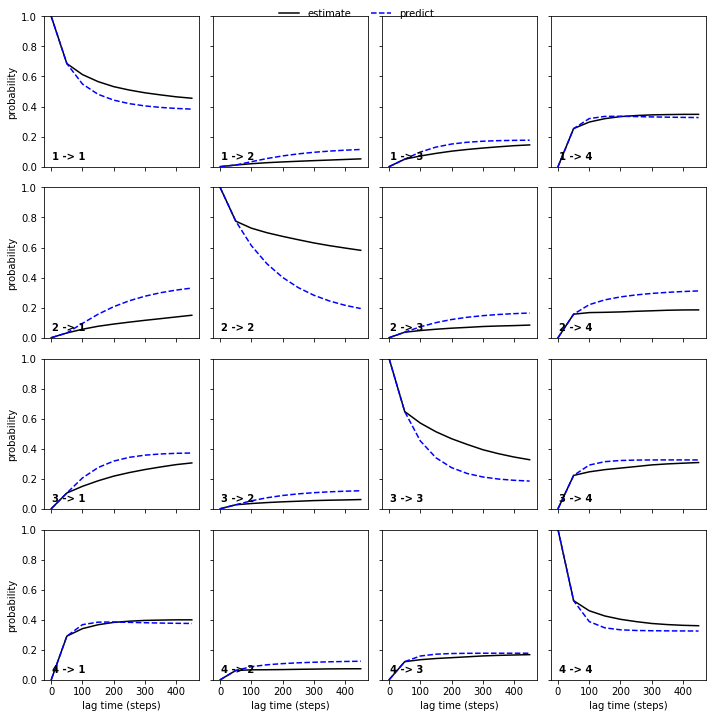

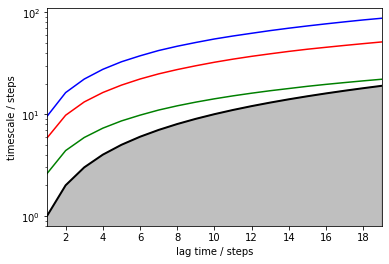

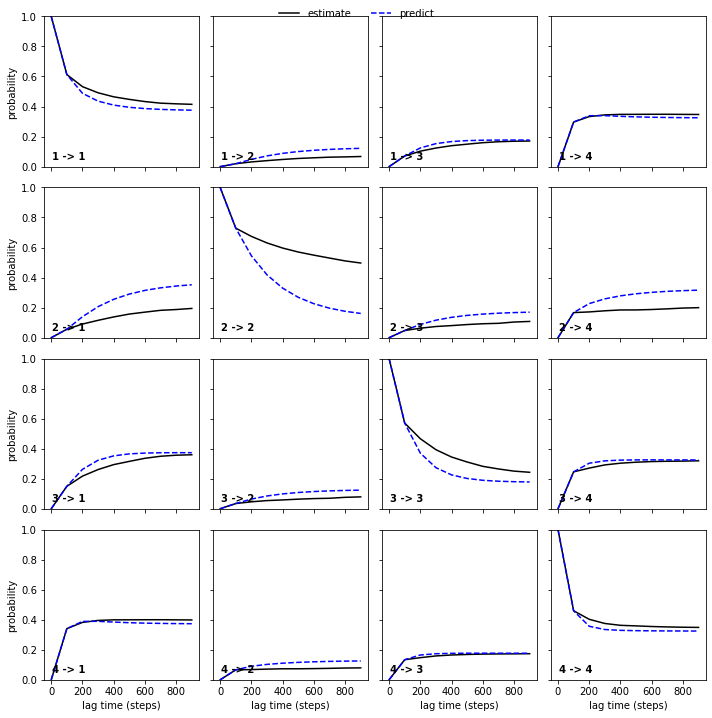

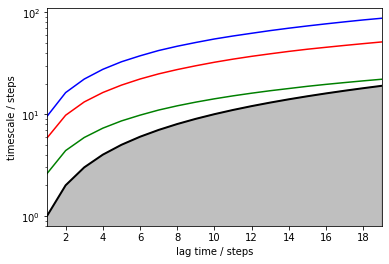

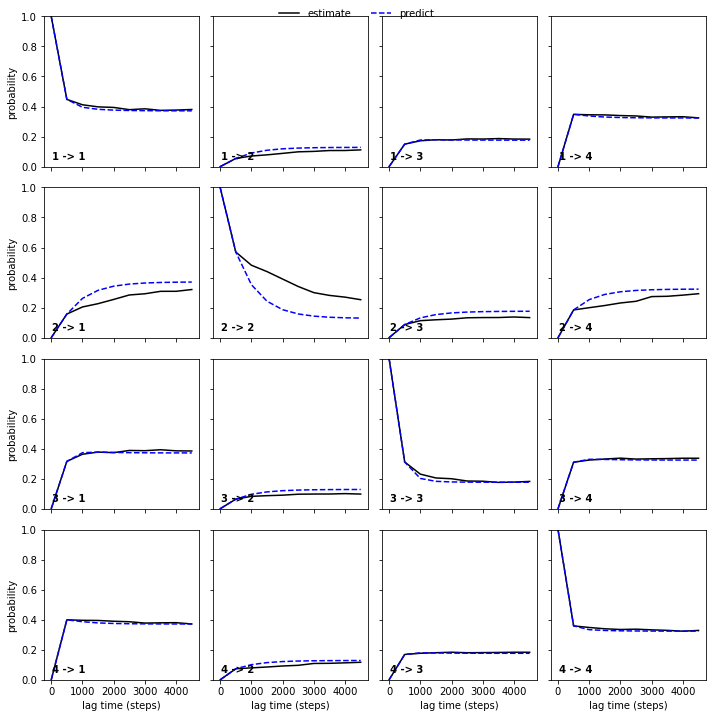

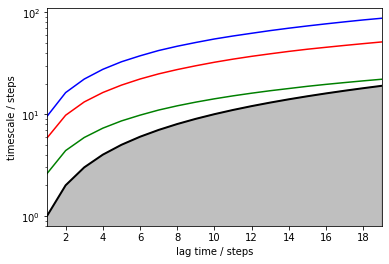

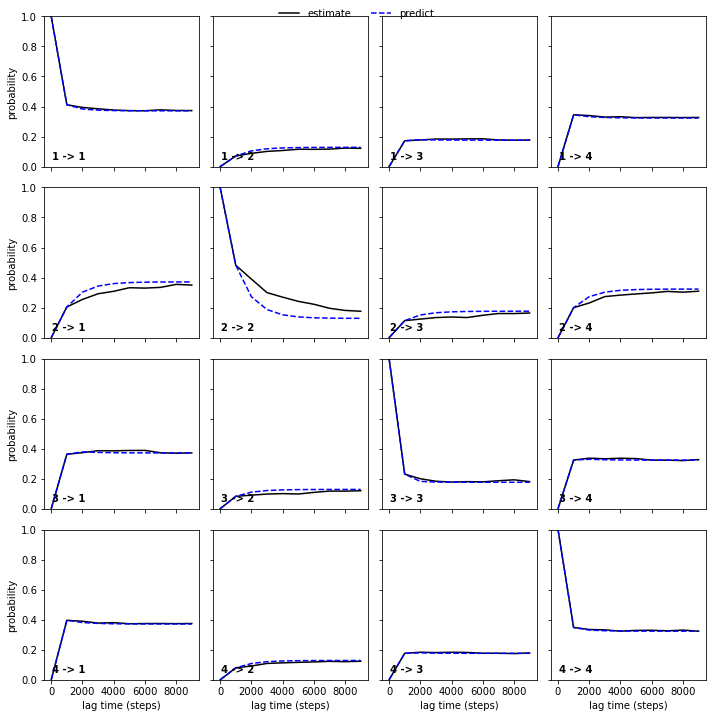

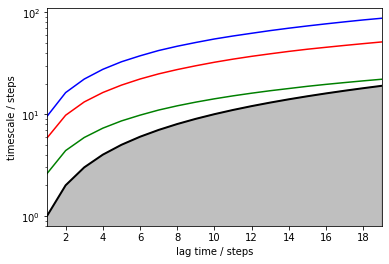

In [55]:
#all to all
msm = []
for i in [5,10,50,100,500,1000]:
    msm.append(makem(dtraj, 4, i))
np.hstack(msm)

([<matplotlib.axis.XTick at 0x7f7d91c909a0>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

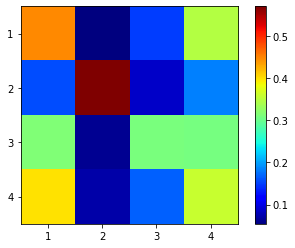

In [56]:
plt.imshow(msm[4].transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [64]:
trj[frames_cl[0]].save_dcd("/Users/achakrab/Documents/asn/tica/fusadil_all_cluster_1.dcd") #save frames
trj[frames_cl[1]].save_dcd("/Users/achakrab/Documents/asn/tica/fusadil_all_cluster_2.dcd") #save frames
trj[frames_cl[2]].save_dcd("/Users/achakrab/Documents/asn/tica/fusadil_all_cluster_3.dcd") #save frames
trj[frames_cl[3]].save_dcd("/Users/achakrab/Documents/asn/tica/fusadil_all_cluster_4.dcd") #save frames